# Q1 数据预处理模块 (Data Preprocessing)

---

## 1. 问题背景与目标

### 1.1 问题背景

**Dancing with the Stars (DWTS)** 是美国著名舞蹈真人秀节目。每周选手的去留由以下两部分决定：

1. **评委打分 (Judge Scores)**: 由专业评委给出，数据已知
2. **粉丝投票 (Fan Votes)**: 由观众投票决定，数据**未公开**

### 1.2 本模块目标

本 Notebook 完成数据预处理工作，为后续的粉丝投票估计模型提供干净、结构化的数据：

| 步骤 | 任务 | 输出 |
|------|------|------|
| Step 1 | 加载原始数据 | `raw_df` |
| Step 2 | 处理缺失值 (N/A, 0分) | 清洗后的评分 |
| Step 3 | 计算评委总分/平均分 | $S_{i,s,t}$, $\bar{S}_{i,s,t}$ |
| Step 4 | 构建有效参赛者集合 | $A_{s,t}$ |
| Step 5 | 提取淘汰标签 | $E_{s,t}$ |
| Step 6 | 保存处理后数据 | CSV, JSON, Pickle |

---

## 2. 数学符号定义 (Mathematical Notation)

为便于后续论文写作，我们在此统一定义所有数学符号：

### 2.1 基本符号

| 符号 | 含义 | 取值范围 |
|------|------|----------|
| $s$ | 赛季编号 (Season) | $s \in \{1, 2, \ldots, 34\}$ |
| $t$ | 周次 (Week) | $t \in \{1, 2, \ldots, T_s\}$，$T_s$ 为赛季 $s$ 的总周数 |
| $i$ | 参赛者编号 (Contestant) | $i \in A_{s,t}$ |
| $j$ | 评委编号 (Judge) | $j \in \{1, 2, 3, 4\}$ |

### 2.2 集合符号

| 符号 | 含义 | 定义 |
|------|------|------|
| $A_{s,t}$ | 有效参赛者集合 | 赛季 $s$ 第 $t$ 周**仍在比赛**的选手集合 |
| $n_{s,t}$ | 有效参赛人数 | $n_{s,t} = |A_{s,t}|$ |
| $E_{s,t}$ | 淘汰者集合 | 赛季 $s$ 第 $t$ 周**被淘汰**的选手集合 |

### 2.3 评分符号

| 符号 | 含义 | 公式 |
|------|------|------|
| $X_{i,s,t,j}$ | 原始评分 | 参赛者 $i$ 在赛季 $s$ 第 $t$ 周来自评委 $j$ 的评分 |
| $\mathbb{1}_{i,s,t,j}$ | 有效指示函数 | $\mathbb{1}_{i,s,t,j} = 1$ 当且仅当 $X_{i,s,t,j}$ 非缺失且 $> 0$ |
| $m_{i,s,t}$ | 有效评委数 | $m_{i,s,t} = \sum_{j=1}^{4} \mathbb{1}_{i,s,t,j}$ |
| $S_{i,s,t}$ | 评委总分 | $S_{i,s,t} = \sum_{j=1}^{4} X_{i,s,t,j} \cdot \mathbb{1}_{i,s,t,j}$ |
| $\bar{S}_{i,s,t}$ | 评委平均分 | $\bar{S}_{i,s,t} = \frac{S_{i,s,t}}{m_{i,s,t}}$ |

---

## 3. 环境配置

In [61]:
# ==============================================================================
# 3.1 导入 Python 标准库
# ==============================================================================
# re: 正则表达式库，用于从字符串中提取淘汰周次等信息
# warnings: 警告控制，用于忽略不影响结果的警告信息
# pathlib.Path: 面向对象的文件路径处理，比 os.path 更现代化
# typing: 类型注解，提高代码可读性和 IDE 支持

import re
import warnings
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Set, Any

# ==============================================================================
# 3.2 导入数据处理库
# ==============================================================================
# pandas: 数据分析核心库，提供 DataFrame 数据结构
# numpy: 数值计算库，提供高效的数组操作

import pandas as pd
import numpy as np

# ==============================================================================
# 3.3 导入可视化库
# ==============================================================================
# matplotlib: Python 基础绑图库
# seaborn: 基于 matplotlib 的统计可视化库，图表更美观

import matplotlib.pyplot as plt
import seaborn as sns

# ==============================================================================
# 3.4 导入序列化库 (用于保存处理后的数据)
# ==============================================================================
# json: 保存为 JSON 格式，便于跨语言读取
# pickle: 保存为 Python 原生格式，保留完整数据类型

import json
import pickle

# ==============================================================================
# 3.5 全局配置
# ==============================================================================

# 忽略警告信息 (如 pandas 的 SettingWithCopyWarning)
warnings.filterwarnings('ignore')

# pandas 显示设置
pd.set_option('display.max_columns', 20)   # 最多显示 20 列
pd.set_option('display.max_rows', 50)      # 最多显示 50 行
pd.set_option('display.width', 200)        # 显示宽度
pd.set_option('display.float_format', '{:.4f}'.format)  # 浮点数显示 4 位小数

# matplotlib 绑图设置
plt.rcParams['figure.figsize'] = (12, 6)   # 默认图表大小
plt.rcParams['figure.dpi'] = 100           # 图表分辨率
plt.rcParams['font.size'] = 10             # 字体大小
plt.rcParams['axes.grid'] = True           # 显示网格
plt.rcParams['grid.alpha'] = 0.3           # 网格透明度

print("✓ 所有库导入成功!")
print(f"  - pandas 版本: {pd.__version__}")
print(f"  - numpy 版本: {np.__version__}")

✓ 所有库导入成功!
  - pandas 版本: 2.3.3
  - numpy 版本: 2.2.6


---

## 4. 数据加载 (Data Loading)

### 4.1 数据来源

原始数据文件: `2026_MCM_Problem_C_Data.csv`

**数据结构说明:**

| 列类型 | 列名格式 | 说明 |
|--------|----------|------|
| 基本信息 | `celebrity_name`, `season`, etc. | 选手基本信息 |
| 评分数据 | `week{t}_judge{j}_score` | 第 $t$ 周评委 $j$ 的评分 |

**特殊值处理:**

| 值 | 含义 | 处理方式 |
|-----|------|----------|
| `N/A` | 该周无第四位评委 | 视为缺失，不参与计算 |
| `0` | 选手已被淘汰 | 视为无效，不参与计算 |

In [62]:
# ==============================================================================
# 4.2 定义数据路径
# ==============================================================================

# 数据目录路径 (相对于当前 notebook)
# Path 对象支持 / 操作符拼接路径，比字符串拼接更安全
DATA_DIR = Path("../data/raw")

# 原始数据文件完整路径
RAW_DATA_PATH = DATA_DIR / "2026_MCM_Problem_C_Data.csv"

# 输出目录 (保存处理后的数据)
OUTPUT_DIR = Path("./processed_data")

# ==============================================================================
# 4.3 检查文件是否存在
# ==============================================================================

print("数据路径检查:")
print("=" * 60)

if RAW_DATA_PATH.exists():
    # 文件存在，显示文件信息
    file_size_kb = RAW_DATA_PATH.stat().st_size / 1024  # 转换为 KB
    print(f"✓ 数据文件存在")
    print(f"  路径: {RAW_DATA_PATH.absolute()}")
    print(f"  大小: {file_size_kb:.2f} KB")
else:
    # 文件不存在，报错
    print(f"✗ 错误: 数据文件不存在!")
    print(f"  期望路径: {RAW_DATA_PATH.absolute()}")
    print(f"  请检查文件是否已下载到正确位置")

数据路径检查:
✓ 数据文件存在
  路径: c:\Users\Administrator\PycharmProjects\AmericaMathModel\2026_MathModel_C\solution_v2\..\data\raw\2026_MCM_Problem_C_Data.csv
  大小: 87.89 KB


In [63]:
# ==============================================================================
# 4.4 加载原始数据
# ==============================================================================

# 使用 pandas 读取 CSV 文件
# encoding='utf-8-sig': 处理可能存在的 BOM (Byte Order Mark) 标记
#                       BOM 是 Windows 系统保存 UTF-8 文件时可能添加的特殊字符
raw_df = pd.read_csv(RAW_DATA_PATH, encoding='utf-8-sig')

# ==============================================================================
# 4.5 显示数据基本信息
# ==============================================================================

print("\n原始数据基本信息:")
print("=" * 60)

# 数据形状: (行数, 列数)
n_rows, n_cols = raw_df.shape
print(f"数据形状: {n_rows} 行 × {n_cols} 列")

# 赛季范围
season_min = raw_df['season'].min()  # 最小赛季编号
season_max = raw_df['season'].max()  # 最大赛季编号
print(f"赛季范围: Season {season_min} - Season {season_max}")

# 参赛者数量
n_contestants = raw_df['celebrity_name'].nunique()  # nunique() 计算唯一值数量
print(f"总参赛者数: {n_contestants} 人")

# 每赛季平均参赛人数
avg_per_season = n_rows / (season_max - season_min + 1)
print(f"每赛季平均参赛人数: {avg_per_season:.1f} 人")


原始数据基本信息:
数据形状: 421 行 × 53 列
赛季范围: Season 1 - Season 34
总参赛者数: 408 人
每赛季平均参赛人数: 12.4 人


In [64]:
# ==============================================================================
# 4.6 分析数据列结构
# ==============================================================================

print("\n数据列结构分析:")
print("=" * 60)

# ------------------------------------------------------------------------------
# 将列名分为两类:
# 1. 基本信息列 (info_cols): 选手姓名、赛季、排名等
# 2. 评分列 (score_cols): week{t}_judge{j}_score 格式的评分数据
# ------------------------------------------------------------------------------

# 基本信息列 (手动定义)
INFO_COLS = [
    'celebrity_name',           # 名人姓名
    'ballroom_partner',         # 职业舞伴姓名
    'celebrity_industry',       # 名人职业类别 (Actor, Athlete, Singer 等)
    'celebrity_homestate',      # 名人家乡州
    'celebrity_homecountry/region',  # 名人家乡国家/地区
    'celebrity_age_during_season',   # 参赛时年龄
    'season',                   # 赛季编号
    'results',                  # 比赛结果 (如 "Eliminated Week 3", "1st Place")
    'placement'                 # 最终排名 (1 = 冠军)
]

# 评分列 (通过正则表达式自动识别)
# 匹配格式: week{数字}_judge{数字}_score
SCORE_COLS = [col for col in raw_df.columns 
              if re.match(r'week\d+_judge\d+_score', col)]

print(f"基本信息列: {len(INFO_COLS)} 列")
for col in INFO_COLS:
    print(f"  - {col}")

print(f"\n评分列: {len(SCORE_COLS)} 列")
print(f"  格式: week{{1-11}}_judge{{1-4}}_score")
print(f"  示例: {SCORE_COLS[:3]} ...")


数据列结构分析:
基本信息列: 9 列
  - celebrity_name
  - ballroom_partner
  - celebrity_industry
  - celebrity_homestate
  - celebrity_homecountry/region
  - celebrity_age_during_season
  - season
  - results
  - placement

评分列: 44 列
  格式: week{1-11}_judge{1-4}_score
  示例: ['week1_judge1_score', 'week1_judge2_score', 'week1_judge3_score'] ...


In [65]:
# ==============================================================================
# 4.7 查看数据样例
# ==============================================================================

print("\n数据样例 (前 5 行, 基本信息列):")
print("=" * 60)

# display() 函数在 Jupyter 中提供更美观的表格显示
# 如果在普通 Python 环境中运行，可以用 print() 替代
display(raw_df[INFO_COLS].head())


数据样例 (前 5 行, 基本信息列):


,celebrity_name,ballroom_partner,celebrity_industry,celebrity_homestate,celebrity_homecountry/region,celebrity_age_during_season,season,results,placement
0,John O'Hurley,Charlotte Jorgensen,Actor/Actress,Maine,United States,50,1,2nd Place,2
1,Kelly Monaco,Alec Mazo,Actor/Actress,Pennsylvania,United States,29,1,1st Place,1
2,Evander Holyfield,Edyta Sliwinska,Athlete,Alabama,United States,42,1,Eliminated Week 3,5
3,Rachel Hunter,Jonathan Roberts,Model,NaN,New Zealand,35,1,Eliminated Week 4,4
4,Joey McIntyre,Ashly DelGrosso,Singer/Rapper,Massachusetts,United States,32,1,3rd Place,3


In [66]:
# ==============================================================================
# 4.8 查看评分数据样例
# ==============================================================================

print("\n评分数据样例 (前 5 行, 第 1-2 周):")
print("=" * 60)

# 选择第 1-2 周的评分列
week1_2_cols = ['celebrity_name', 'season'] + [
    col for col in SCORE_COLS 
    if col.startswith('week1_') or col.startswith('week2_')
]

display(raw_df[week1_2_cols].head())


评分数据样例 (前 5 行, 第 1-2 周):


,celebrity_name,season,week1_judge1_score,week1_judge2_score,week1_judge3_score,week1_judge4_score,week2_judge1_score,week2_judge2_score,week2_judge3_score,week2_judge4_score
0,John O'Hurley,1,7.0000,7.0000,6.0000,NaN,8.0000,9.0000,9.0000,NaN
1,Kelly Monaco,1,5.0000,4.0000,4.0000,NaN,5.0000,6.0000,6.0000,NaN
2,Evander Holyfield,1,5.0000,7.0000,6.0000,NaN,5.0000,4.0000,5.0000,NaN
3,Rachel Hunter,1,7.0000,6.0000,7.0000,NaN,8.0000,8.0000,8.0000,NaN
4,Joey McIntyre,1,7.0000,7.0000,6.0000,NaN,8.0000,7.0000,6.0000,NaN


---

## 5. 缺失值分析 (Missing Value Analysis)

### 5.1 缺失值类型

在 DWTS 数据中，存在以下几种"缺失"情况：

| 类型 | 表现形式 | 含义 | 处理方式 |
|------|----------|------|----------|
| 真缺失 | `NaN` / 空值 | 数据未记录 | 标记为无效 |
| N/A 字符串 | `'N/A'` | 该周无第四位评委 | 标记为无效 |
| 零分 | `0` | 选手已被淘汰 | 标记为无效 |

### 5.2 数学定义

定义**有效指示函数** $\mathbb{1}_{i,s,t,j}$：

$$
\mathbb{1}_{i,s,t,j} = 
\begin{cases}
1 & \text{if } X_{i,s,t,j} \text{ 存在且 } X_{i,s,t,j} > 0 \\
0 & \text{otherwise}
\end{cases}
$$

其中 $X_{i,s,t,j}$ 为原始评分值。

In [67]:
# ==============================================================================
# 5.3 分析真缺失值 (NaN)
# ==============================================================================

print("缺失值分析 - 真缺失 (NaN):")
print("=" * 60)

# 计算每列的缺失值数量
# isnull() 返回布尔 DataFrame，True 表示缺失
# sum() 对布尔值求和，True=1, False=0
missing_count = raw_df.isnull().sum()

# 计算缺失比例 (百分比)
missing_pct = (missing_count / len(raw_df) * 100).round(2)

# 创建缺失值汇总表
missing_summary = pd.DataFrame({
    '缺失数量': missing_count,
    '缺失比例(%)': missing_pct
})

# 只显示有缺失值的列
missing_summary = missing_summary[missing_summary['缺失数量'] > 0]

if len(missing_summary) > 0:
    print("存在缺失值的列:")
    display(missing_summary)
else:
    print("✓ 所有列均无真缺失值 (NaN)")

缺失值分析 - 真缺失 (NaN):
存在缺失值的列:


,缺失数量,缺失比例(%)
celebrity_homestate,56,13.3000
week1_judge3_score,14,3.3300
week1_judge4_score,340,80.7600
week2_judge4_score,330,78.3800
week3_judge4_score,293,69.6000
week4_judge4_score,291,69.1200
week5_judge1_score,10,2.3800
week5_judge2_score,10,2.3800
week5_judge3_score,10,2.3800
week5_judge4_score,302,71.7300


In [68]:
# ==============================================================================
# 5.4 分析 'N/A' 字符串
# ==============================================================================

print("\n缺失值分析 - 'N/A' 字符串:")
print("=" * 60)

# 统计每个评分列中 'N/A' 的数量
na_string_counts = {}
for col in SCORE_COLS:
    # 统计该列中值为 'N/A' 的行数
    na_count = (raw_df[col] == 'N/A').sum()
    if na_count > 0:
        na_string_counts[col] = na_count

# 按周次汇总 N/A 数量
# 目的: 了解哪些周次更容易出现 N/A (通常是第四位评委缺席)
week_na_summary = {}
for col, count in na_string_counts.items():
    # 从列名中提取周次数字
    # 例如: 'week3_judge4_score' -> 提取 '3'
    week_match = re.search(r'week(\d+)', col)
    if week_match:
        week = int(week_match.group(1))
        week_na_summary[week] = week_na_summary.get(week, 0) + count

print(f"各周 'N/A' 值总数:")
for week in sorted(week_na_summary.keys()):
    print(f"  Week {week}: {week_na_summary[week]} 个")

# 分析: N/A 主要出现在 judge4 列
judge4_na = sum(1 for col in na_string_counts if 'judge4' in col)
print(f"\n其中 judge4 列的 N/A: {judge4_na} 列 (说明第四位评委经常缺席)")


缺失值分析 - 'N/A' 字符串:
各周 'N/A' 值总数:

其中 judge4 列的 N/A: 0 列 (说明第四位评委经常缺席)


In [69]:
# ==============================================================================
# 5.5 分析零分 (已淘汰选手)
# ==============================================================================

print("\n缺失值分析 - 零分 (已淘汰):")
print("=" * 60)

# 统计每个评分列中零分的数量
# 注意: 需要先将列转换为数值类型，因为可能包含 'N/A' 字符串
zero_counts = {}
for col in SCORE_COLS:
    # pd.to_numeric 将值转换为数值，无法转换的 (如 'N/A') 变为 NaN
    numeric_col = pd.to_numeric(raw_df[col], errors='coerce')
    # 统计零值数量
    zero_count = (numeric_col == 0).sum()
    if zero_count > 0:
        zero_counts[col] = zero_count

# 按周次汇总零分数量
week_zero_summary = {}
for col, count in zero_counts.items():
    week_match = re.search(r'week(\d+)', col)
    if week_match:
        week = int(week_match.group(1))
        week_zero_summary[week] = week_zero_summary.get(week, 0) + count

print(f"各周零分 (已淘汰) 数量:")
for week in sorted(week_zero_summary.keys()):
    print(f"  Week {week}: {week_zero_summary[week]} 个")

print("\n说明: 零分数量随周次增加而增加，因为越来越多选手被淘汰")


缺失值分析 - 零分 (已淘汰):
各周零分 (已淘汰) 数量:
  Week 2: 55 个
  Week 3: 204 个
  Week 4: 312 个
  Week 5: 401 个
  Week 6: 498 个
  Week 7: 591 个
  Week 8: 695 个
  Week 9: 806 个
  Week 10: 845 个
  Week 11: 264 个

说明: 零分数量随周次增加而增加，因为越来越多选手被淘汰


---

## 6. 数据清洗函数定义 (Data Cleaning Functions)

本节定义所有数据清洗相关的函数，每个函数都有详细的文档字符串和注释。

In [70]:
# ==============================================================================
# 6.1 定义评分解析函数
# ==============================================================================

def parse_score(value: Any) -> Optional[float]:
    """
    解析单个评分值，实现有效指示函数 𝟙_{i,s,t,j}
    
    数学定义:
    ---------
    该函数实现了有效指示函数的判断逻辑:
    
        𝟙_{i,s,t,j} = 1  当且仅当 X_{i,s,t,j} 存在且 > 0
    
    当 𝟙 = 1 时，返回评分值 X；否则返回 None。
    
    参数:
    -----
    value : Any
        原始评分值，可能的类型包括:
        - float/int: 有效评分 (如 8, 7.5)
        - str: 'N/A' 表示无评委
        - 0: 表示选手已淘汰
        - None/NaN: 缺失值
    
    返回:
    -----
    Optional[float]
        - float: 有效评分值 (> 0)
        - None: 无效评分 (N/A, 0, 缺失等)
    
    示例:
    -----
    >>> parse_score(8)      # 有效评分
    8.0
    >>> parse_score(7.5)    # 有效评分 (小数)
    7.5
    >>> parse_score('N/A')  # 无第四位评委
    None
    >>> parse_score(0)      # 已淘汰
    None
    >>> parse_score(None)   # 缺失
    None
    """
    # --------------------------------------------------
    # Step 1: 处理 Python 缺失值 (None, NaN)
    # --------------------------------------------------
    # pd.isna() 可以同时检测 None 和 np.nan
    if pd.isna(value):
        return None
    
    # --------------------------------------------------
    # Step 2: 处理 'N/A' 字符串
    # --------------------------------------------------
    # 'N/A' 表示该周没有第四位评委，视为无效
    if value == 'N/A':
        return None
    
    # --------------------------------------------------
    # Step 3: 尝试转换为浮点数并检查是否 > 0
    # --------------------------------------------------
    try:
        score = float(value)
        # 0 分表示选手已被淘汰，视为无效
        # 有效评分范围通常是 1-10 分
        if score > 0:
            return score
        else:
            return None
    except (ValueError, TypeError):
        # 无法转换为数值，视为无效
        return None


# ------------------------------------------------------------------------------
# 测试 parse_score 函数
# ------------------------------------------------------------------------------
print("parse_score() 函数测试:")
print("-" * 40)

test_cases = [
    (8, "有效整数评分"),
    (7.5, "有效小数评分"),
    ('N/A', "无第四位评委"),
    (0, "已淘汰 (零分)"),
    (None, "Python None"),
    (np.nan, "NumPy NaN"),
    ('9', "字符串数字")
]

for value, description in test_cases:
    result = parse_score(value)
    print(f"  {repr(value):10} ({description:15}) -> {result}")

parse_score() 函数测试:
----------------------------------------
  8          (有效整数评分         ) -> 8.0
  7.5        (有效小数评分         ) -> 7.5
  'N/A'      (无第四位评委         ) -> None
  0          (已淘汰 (零分)       ) -> None
  None       (Python None    ) -> None
  nan        (NumPy NaN      ) -> None
  '9'        (字符串数字          ) -> 9.0


In [71]:
# ==============================================================================
# 6.2 定义淘汰周次解析函数
# ==============================================================================

def parse_elimination_week(results: str) -> Optional[int]:
    """
    从 results 字段解析选手的淘汰周次
    
    背景说明:
    ---------
    原始数据的 'results' 列记录了每位选手的比赛结果，格式如:
    - "Eliminated Week 3": 第 3 周被淘汰
    - "1st Place": 冠军 (未被淘汰)
    - "Withdrew": 主动退赛
    
    参数:
    -----
    results : str
        比赛结果字符串
    
    返回:
    -----
    Optional[int]
        - 正整数: 淘汰周次 (如 3 表示第 3 周被淘汰)
        - -1: 主动退赛 (Withdrew)
        - None: 未被淘汰 (进入决赛的选手)
    
    示例:
    -----
    >>> parse_elimination_week("Eliminated Week 3")
    3
    >>> parse_elimination_week("1st Place")
    None
    >>> parse_elimination_week("Withdrew")
    -1
    
    论文写作提示:
    -------------
    可以定义淘汰指示变量:
    
        e_{i,s,t} = 1  当且仅当选手 i 在赛季 s 第 t 周被淘汰
    
    则淘汰者集合: E_{s,t} = {i : e_{i,s,t} = 1}
    """
    # --------------------------------------------------
    # Step 1: 处理空值
    # --------------------------------------------------
    if pd.isna(results):
        return None
    
    # 转换为字符串并去除首尾空格
    results = str(results).strip()
    
    # --------------------------------------------------
    # Step 2: 使用正则表达式匹配 "Eliminated Week X" 格式
    # --------------------------------------------------
    # 正则表达式说明:
    # - r'Eliminated Week (\d+)': 匹配 "Eliminated Week" 后跟数字
    # - (\d+): 捕获组，提取周次数字
    # - re.IGNORECASE: 忽略大小写
    match = re.search(r'Eliminated Week (\d+)', results, re.IGNORECASE)
    if match:
        # group(1) 返回第一个捕获组的内容 (周次数字)
        return int(match.group(1))
    
    # --------------------------------------------------
    # Step 3: 处理退赛情况
    # --------------------------------------------------
    # 有些选手因个人原因主动退出比赛
    if 'Withdrew' in results or 'Quit' in results:
        return -1  # 用 -1 标记退赛，与正常淘汰区分
    
    # --------------------------------------------------
    # Step 4: 其他情况 (未被淘汰)
    # --------------------------------------------------
    # 包括: "1st Place", "2nd Place", "3rd Place" 等
    # 这些选手进入了决赛，未被淘汰
    return None


# ------------------------------------------------------------------------------
# 测试 parse_elimination_week 函数
# ------------------------------------------------------------------------------
print("parse_elimination_week() 函数测试:")
print("-" * 50)

test_results = [
    ("Eliminated Week 3", "正常淘汰"),
    ("Eliminated Week 10", "后期淘汰"),
    ("1st Place", "冠军"),
    ("2nd Place", "亚军"),
    ("3rd Place", "季军"),
    ("Withdrew", "主动退赛"),
    (None, "空值")
]

for value, description in test_results:
    result = parse_elimination_week(value)
    print(f"  {str(value):25} ({description:10}) -> {result}")

parse_elimination_week() 函数测试:
--------------------------------------------------
  Eliminated Week 3         (正常淘汰      ) -> 3
  Eliminated Week 10        (后期淘汰      ) -> 10
  1st Place                 (冠军        ) -> None
  2nd Place                 (亚军        ) -> None
  3rd Place                 (季军        ) -> None
  Withdrew                  (主动退赛      ) -> -1
  None                      (空值        ) -> None


In [72]:
# ==============================================================================
# 6.3 定义每周评分计算函数
# ==============================================================================

def compute_weekly_judge_score(
    row: pd.Series, 
    week: int
) -> Tuple[Optional[float], Optional[float], int]:
    """
    计算某位选手某周的评委总分和平均分
    
    数学公式:
    ---------
    设 X_{i,s,t,j} 为选手 i 在赛季 s 第 t 周来自评委 j 的评分，
    𝟙_{i,s,t,j} 为有效指示函数。
    
    1. 有效评委数:
       m_{i,s,t} = Σ_{j=1}^{4} 𝟙_{i,s,t,j}
    
    2. 评委总分:
       S_{i,s,t} = Σ_{j=1}^{4} X_{i,s,t,j} · 𝟙_{i,s,t,j}
    
    3. 评委平均分:
       S̄_{i,s,t} = S_{i,s,t} / m_{i,s,t}  (当 m > 0 时)
    
    参数:
    -----
    row : pd.Series
        DataFrame 的一行，包含该选手的所有数据
    week : int
        要计算的周次 (1-11)
    
    返回:
    -----
    Tuple[Optional[float], Optional[float], int]
        - total_score: 评委总分 S_{i,s,t}，无有效评分时为 None
        - avg_score: 评委平均分 S̄_{i,s,t}，无有效评分时为 None
        - judge_count: 有效评委数 m_{i,s,t}
    
    示例:
    -----
    假设某选手第 1 周的评分为 [8, 7, 9, N/A]:
    - 有效评分: [8, 7, 9] (3 个)
    - 总分: 8 + 7 + 9 = 24
    - 平均分: 24 / 3 = 8.0
    """
    # --------------------------------------------------
    # Step 1: 收集该周所有评委的有效评分
    # --------------------------------------------------
    valid_scores = []  # 存储有效评分的列表
    
    # 遍历 4 位评委 (j = 1, 2, 3, 4)
    for judge in range(1, 5):
        # 构造列名: week{t}_judge{j}_score
        col_name = f'week{week}_judge{judge}_score'
        
        # 检查该列是否存在于数据中
        if col_name in row.index:
            # 使用 parse_score 函数解析评分
            score = parse_score(row[col_name])
            
            # 如果评分有效 (非 None)，添加到列表
            if score is not None:
                valid_scores.append(score)
    
    # --------------------------------------------------
    # Step 2: 计算总分和平均分
    # --------------------------------------------------
    judge_count = len(valid_scores)  # 有效评委数 m_{i,s,t}
    
    if judge_count > 0:
        # 有有效评分，计算总分和平均分
        total_score = sum(valid_scores)           # S_{i,s,t}
        avg_score = total_score / judge_count     # S̄_{i,s,t}
        return total_score, avg_score, judge_count
    else:
        # 无有效评分 (选手未参赛或已淘汰)
        return None, None, 0


# ------------------------------------------------------------------------------
# 测试 compute_weekly_judge_score 函数
# ------------------------------------------------------------------------------
print("compute_weekly_judge_score() 函数测试:")
print("-" * 50)

# 使用第一行数据进行测试
test_row = raw_df.iloc[0]
print(f"测试选手: {test_row['celebrity_name']} (Season {test_row['season']})")
print()

# 计算前 3 周的评分
for week in range(1, 4):
    total, avg, count = compute_weekly_judge_score(test_row, week)
    if total is not None:
        print(f"  Week {week}: 总分={total:.1f}, 平均分={avg:.2f}, 评委数={count}")
    else:
        print(f"  Week {week}: 无有效评分 (可能已淘汰或未参赛)")

compute_weekly_judge_score() 函数测试:
--------------------------------------------------
测试选手: John O'Hurley (Season 1)

  Week 1: 总分=20.0, 平均分=6.67, 评委数=3
  Week 2: 总分=26.0, 平均分=8.67, 评委数=3
  Week 3: 总分=24.0, 平均分=8.00, 评委数=3


---

## 7. 完整数据处理流程 (Complete Data Processing)

本节将上述函数整合，对所有选手的所有周次进行处理。

In [73]:
# ==============================================================================
# 7.1 定义完整的数据处理函数
# ==============================================================================

def process_all_contestants(
    df: pd.DataFrame, 
    max_weeks: int = 11
) -> pd.DataFrame:
    """
    处理所有选手的数据，计算每周评分并提取淘汰信息
    
    处理流程:
    ---------
    对于每位选手 i 在赛季 s:
    1. 提取基本信息 (姓名、赛季、排名等)
    2. 解析淘汰周次
    3. 对每周 t = 1, 2, ..., T_s:
       - 计算评委总分 S_{i,s,t}
       - 计算评委平均分 S̄_{i,s,t}
       - 记录有效评委数 m_{i,s,t}
    
    参数:
    -----
    df : pd.DataFrame
        原始数据 DataFrame
    max_weeks : int, default=11
        最大周数 (DWTS 通常最多 11 周)
    
    返回:
    -----
    pd.DataFrame
        处理后的数据，包含以下列:
        - 基本信息: celebrity_name, ballroom_partner, season, placement, etc.
        - 淘汰信息: elimination_week
        - 每周评分: week{t}_total_score, week{t}_avg_score, week{t}_judge_count
    
    输出数据结构:
    -------------
    | celebrity_name | season | elimination_week | week1_total_score | week1_avg_score | ... |
    |----------------|--------|------------------|-------------------|-----------------|-----|
    | John O'Hurley  | 1      | None             | 20.0              | 6.67            | ... |
    | Kelly Monaco   | 1      | None             | 13.0              | 4.33            | ... |
    """
    # 存储所有处理后的记录
    processed_records = []
    
    # --------------------------------------------------
    # 遍历每位选手 (每行数据)
    # --------------------------------------------------
    # 使用 iterrows() 遍历 DataFrame 的每一行
    # idx: 行索引, row: 该行数据 (pd.Series)
    for idx, row in df.iterrows():
        
        # ----------------------------------------------
        # Step 1: 提取基本信息
        # ----------------------------------------------
        record = {
            # 选手标识信息
            'celebrity_name': row['celebrity_name'],      # 名人姓名
            'ballroom_partner': row['ballroom_partner'],  # 职业舞伴
            'season': row['season'],                      # 赛季编号 s
            
            # 比赛结果信息
            'placement': row['placement'],                # 最终排名
            'results': row['results'],                    # 原始结果字符串
            
            # 解析淘汰周次
            'elimination_week': parse_elimination_week(row['results']),
            
            # 选手属性信息 (用于后续分析)
            'celebrity_industry': row.get('celebrity_industry', ''),
            'celebrity_age': row.get('celebrity_age_during_season', np.nan),
        }
        
        # ----------------------------------------------
        # Step 2: 计算每周评分
        # ----------------------------------------------
        for week in range(1, max_weeks + 1):
            # 调用评分计算函数
            total_score, avg_score, judge_count = compute_weekly_judge_score(row, week)
            
            # 存储结果
            # 列名格式: week{t}_{metric}
            record[f'week{week}_total_score'] = total_score   # S_{i,s,t}
            record[f'week{week}_avg_score'] = avg_score       # S̄_{i,s,t}
            record[f'week{week}_judge_count'] = judge_count   # m_{i,s,t}
        
        # 将该选手的记录添加到列表
        processed_records.append(record)
    
    # --------------------------------------------------
    # Step 3: 转换为 DataFrame 并返回
    # --------------------------------------------------
    return pd.DataFrame(processed_records)


print("✓ process_all_contestants() 函数定义完成")

✓ process_all_contestants() 函数定义完成


In [74]:
# ==============================================================================
# 7.2 执行数据处理
# ==============================================================================

print("开始处理数据...")
print("=" * 60)

# 调用处理函数
# 这一步会遍历所有 421 位选手，计算每周评分
processed_df = process_all_contestants(raw_df, max_weeks=11)

# 显示处理结果
print(f"\n处理完成!")
print(f"  - 原始数据: {raw_df.shape[0]} 行 × {raw_df.shape[1]} 列")
print(f"  - 处理后数据: {processed_df.shape[0]} 行 × {processed_df.shape[1]} 列")

# 显示新增的列
new_cols = [col for col in processed_df.columns if col not in INFO_COLS]
print(f"  - 新增列数: {len(new_cols)}")

开始处理数据...

处理完成!
  - 原始数据: 421 行 × 53 列
  - 处理后数据: 421 行 × 41 列
  - 新增列数: 35


In [75]:
# ==============================================================================
# 7.3 查看处理后的数据样例
# ==============================================================================

print("处理后数据样例 (Season 1):")
print("=" * 60)

# 筛选第 1 赛季的数据
season1_df = processed_df[processed_df['season'] == 1].copy()

# 选择要显示的列
display_cols = [
    'celebrity_name',       # 选手姓名
    'elimination_week',     # 淘汰周次
    'placement',            # 最终排名
    'week1_total_score',    # 第 1 周总分
    'week2_total_score',    # 第 2 周总分
    'week3_total_score',    # 第 3 周总分
]

display(season1_df[display_cols])

处理后数据样例 (Season 1):


,celebrity_name,elimination_week,placement,week1_total_score,week2_total_score,week3_total_score
0,John O'Hurley,NaN,2,20.0000,26.0000,24.0000
1,Kelly Monaco,NaN,1,13.0000,17.0000,21.0000
2,Evander Holyfield,3.0000,5,18.0000,14.0000,13.0000
3,Rachel Hunter,4.0000,4,20.0000,24.0000,26.0000
4,Joey McIntyre,NaN,3,20.0000,21.0000,22.0000
5,Trista Sutter,2.0000,6,18.0000,19.0000,NaN


In [76]:
# ==============================================================================
# 7.4 验证数据一致性: 淘汰后应无评分
# ==============================================================================

print("数据一致性验证: 淘汰后应无评分")
print("=" * 60)
print("\n规则: 选手在第 t 周被淘汰后，第 t+1, t+2, ... 周应无有效评分 (NaN)")
print("-" * 60)

# 统计不一致的情况
inconsistent_count = 0

# 遍历所有被淘汰的选手
eliminated_df = processed_df[
    (processed_df['elimination_week'].notna()) &  # 有淘汰周次
    (processed_df['elimination_week'] > 0)        # 排除退赛 (-1)
]

for _, row in eliminated_df.iterrows():
    elim_week = int(row['elimination_week'])  # 淘汰周次
    
    # 检查淘汰后的周次是否有评分
    for week in range(elim_week + 1, 12):
        score = row.get(f'week{week}_total_score')
        if pd.notna(score):  # 如果有评分，说明数据不一致
            inconsistent_count += 1
            print(f"  ✗ 异常: {row['celebrity_name']} (S{row['season']}) "
                  f"第{elim_week}周淘汰，但第{week}周有评分 {score}")

if inconsistent_count == 0:
    print("\n✓ 所有数据一致: 淘汰后均无评分")
else:
    print(f"\n✗ 发现 {inconsistent_count} 处不一致")

数据一致性验证: 淘汰后应无评分

规则: 选手在第 t 周被淘汰后，第 t+1, t+2, ... 周应无有效评分 (NaN)
------------------------------------------------------------

✓ 所有数据一致: 淘汰后均无评分


---

## 8. 构建有效参赛者集合 $A_{s,t}$ 和淘汰者集合 $E_{s,t}$

### 8.1 数学定义

**有效参赛者集合 (Active Contestant Set):**

$$
A_{s,t} = \{i : S_{i,s,t} \text{ 存在且 } S_{i,s,t} > 0\}
$$

即赛季 $s$ 第 $t$ 周有有效评分的选手集合。

**淘汰者集合 (Eliminated Contestant Set):**

$$
E_{s,t} = \{i : \text{选手 } i \text{ 在赛季 } s \text{ 第 } t \text{ 周被淘汰}\}
$$

**集合关系:**

$$
A_{s,t+1} = A_{s,t} \setminus E_{s,t}
$$

即下一周的有效参赛者 = 本周有效参赛者 - 本周淘汰者

In [77]:
# ==============================================================================
# 8.2 定义构建有效参赛者集合的函数
# ==============================================================================

def build_active_contestant_sets(
    df: pd.DataFrame
) -> Dict[int, Dict[int, List[str]]]:
    """
    构建每个赛季每周的有效参赛者集合 A_{s,t}
    
    数学定义:
    ---------
    A_{s,t} = {i : S_{i,s,t} 存在且 > 0}
    
    其中 S_{i,s,t} 为选手 i 在赛季 s 第 t 周的评委总分。
    
    参数:
    -----
    df : pd.DataFrame
        处理后的数据 DataFrame，需包含 week{t}_total_score 列
    
    返回:
    -----
    Dict[int, Dict[int, List[str]]]
        嵌套字典结构:
        {
            season_1: {
                week_1: [contestant_1, contestant_2, ...],
                week_2: [...],
                ...
            },
            season_2: {...},
            ...
        }
    
    示例:
    -----
    >>> active_sets = build_active_contestant_sets(processed_df)
    >>> active_sets[1][1]  # Season 1, Week 1 的参赛者
    ['John O\'Hurley', 'Kelly Monaco', ...]
    """
    active_sets = {}  # 存储结果的字典
    
    # --------------------------------------------------
    # 遍历每个赛季
    # --------------------------------------------------
    for season in sorted(df['season'].unique()):
        # 筛选该赛季的数据
        season_df = df[df['season'] == season]
        
        # 初始化该赛季的字典
        active_sets[season] = {}
        
        # ----------------------------------------------
        # 确定该赛季的最大有效周数 T_s
        # ----------------------------------------------
        # 方法: 找到最后一个有有效评分的周次
        max_week = 0
        for week in range(1, 12):
            col = f'week{week}_total_score'
            # 检查该周是否有任何选手有评分
            if col in season_df.columns and season_df[col].notna().any():
                max_week = week
        
        # ----------------------------------------------
        # 构建每周的有效参赛者集合
        # ----------------------------------------------
        for week in range(1, max_week + 1):
            col = f'week{week}_total_score'
            
            # 筛选该周有有效评分的选手
            # notna() 返回 True 表示非缺失值
            active_contestants = season_df[
                season_df[col].notna()
            ]['celebrity_name'].tolist()
            
            # 存储到字典
            active_sets[season][week] = active_contestants
    
    return active_sets


# 执行构建
print("构建有效参赛者集合 A_{s,t}...")
active_sets = build_active_contestant_sets(processed_df)
print(f"✓ 完成! 共 {len(active_sets)} 个赛季")

构建有效参赛者集合 A_{s,t}...
✓ 完成! 共 34 个赛季


In [78]:
# ==============================================================================
# 8.3 定义构建淘汰者集合的函数
# ==============================================================================

def build_elimination_sets(
    df: pd.DataFrame
) -> Dict[int, Dict[int, List[str]]]:
    """
    构建每个赛季每周的淘汰者集合 E_{s,t}
    
    数学定义:
    ---------
    E_{s,t} = {i : 选手 i 在赛季 s 第 t 周被淘汰}
    
    注意事项:
    ---------
    - 有些周可能没有淘汰: E_{s,t} = ∅
    - 有些周可能淘汰多人: |E_{s,t}| > 1
    - 退赛 (Withdrew) 不计入淘汰集合
    
    参数:
    -----
    df : pd.DataFrame
        处理后的数据 DataFrame，需包含 elimination_week 列
    
    返回:
    -----
    Dict[int, Dict[int, List[str]]]
        嵌套字典结构，只包含有淘汰的周次:
        {
            season_1: {
                week_2: [eliminated_contestant],  # 第 2 周有淘汰
                week_3: [...],
                # week_1 没有淘汰，不包含在字典中
            },
            ...
        }
    """
    elimination_sets = {}  # 存储结果的字典
    
    # --------------------------------------------------
    # 遍历每个赛季
    # --------------------------------------------------
    for season in sorted(df['season'].unique()):
        season_df = df[df['season'] == season]
        elimination_sets[season] = {}
        
        # ----------------------------------------------
        # 遍历每周，找出被淘汰的选手
        # ----------------------------------------------
        for week in range(1, 12):
            # 筛选该周被淘汰的选手
            # elimination_week == week 表示在第 week 周被淘汰
            eliminated = season_df[
                season_df['elimination_week'] == week
            ]['celebrity_name'].tolist()
            
            # 只有当有淘汰时才添加到字典
            if eliminated:
                elimination_sets[season][week] = eliminated
    
    return elimination_sets


# 执行构建
print("构建淘汰者集合 E_{s,t}...")
elimination_sets = build_elimination_sets(processed_df)

# 统计总淘汰次数
total_eliminations = sum(
    len(elim_list) 
    for season_dict in elimination_sets.values() 
    for elim_list in season_dict.values()
)
print(f"✓ 完成! 总淘汰事件数: {total_eliminations}")

构建淘汰者集合 E_{s,t}...
✓ 完成! 总淘汰事件数: 298


In [79]:
# ==============================================================================
# 8.4 显示集合示例
# ==============================================================================

def display_season_sets_detail(season: int):
    """
    详细显示某赛季的有效参赛者和淘汰者集合
    
    显示内容:
    - 每周参赛人数 n_{s,t} = |A_{s,t}|
    - 每周淘汰人数 |E_{s,t}|
    - 淘汰选手姓名
    """
    print(f"\n{'='*70}")
    print(f"Season {season} 集合详情")
    print(f"{'='*70}")
    
    if season not in active_sets:
        print(f"错误: 赛季 {season} 不存在")
        return
    
    season_active = active_sets[season]
    season_elim = elimination_sets.get(season, {})
    
    # 表头
    print(f"\n{'周次':<8} {'参赛人数 n_{s,t}':<18} {'淘汰人数 |E_{s,t}|':<18} {'淘汰选手'}")
    print("-" * 70)
    
    # 遍历每周
    for week in sorted(season_active.keys()):
        n_active = len(season_active[week])           # |A_{s,t}|
        eliminated = season_elim.get(week, [])        # E_{s,t}
        n_elim = len(eliminated)                      # |E_{s,t}|
        elim_names = ', '.join(eliminated) if eliminated else '-'
        
        print(f"Week {week:<4} {n_active:<18} {n_elim:<18} {elim_names}")


# 显示几个示例赛季
for s in [1, 3, 10]:
    display_season_sets_detail(s)


Season 1 集合详情

周次       参赛人数 n_{s,t}       淘汰人数 |E_{s,t}|     淘汰选手
----------------------------------------------------------------------
Week 1    6                  0                  -
Week 2    6                  1                  Trista Sutter
Week 3    5                  1                  Evander Holyfield
Week 4    4                  1                  Rachel Hunter
Week 5    3                  0                  -
Week 6    2                  0                  -

Season 3 集合详情

周次       参赛人数 n_{s,t}       淘汰人数 |E_{s,t}|     淘汰选手
----------------------------------------------------------------------
Week 1    11                 1                  Tucker Carlson
Week 2    10                 1                  Shanna Moakler
Week 3    9                  1                  Harry Hamlin
Week 4    8                  1                  Vivica A. Fox
Week 5    7                  1                  Willa Ford
Week 6    5                  0                  -
Week 7    5             

---

## 9. 投票规则分类 (Voting Rule Classification)

### 9.1 投票规则演变历史

DWTS 的投票规则在不同赛季有所变化，这对我们的粉丝投票估计模型至关重要：

| 赛季范围 | 规则类型 | 数学表达 | 说明 |
|---------|---------|----------|------|
| S1-S2 | 排名制 v1 | $R_i = R_i^{judge} + R_i^{fan}$ | 评委排名 + 粉丝排名，总排名最差者淘汰 |
| S3-S27 | 百分比制 | $T_i = 0.5 \cdot \tilde{S}_i + 0.5 \cdot \tilde{F}_i$ | 评委分占50% + 粉丝票占50%，总分最低者淘汰 |
| S28-S34 | 排名制 v2 | 排名 + 评委拯救 | 排名确定倒数两名，评委投票决定谁被淘汰 |

### 9.2 百分比制详解 (S3-S27)

这是最常用的规则，也是我们建模的重点：

**Step 1: 评委分归一化**

$$
\tilde{S}_{i,s,t} = \frac{S_{i,s,t}}{\sum_{k \in A_{s,t}} S_{k,s,t}} \times 100\%
$$

**Step 2: 粉丝票归一化** (这是我们要估计的)

$$
\tilde{F}_{i,s,t} = \frac{F_{i,s,t}}{\sum_{k \in A_{s,t}} F_{k,s,t}} \times 100\%
$$

**Step 3: 计算综合得分**

$$
T_{i,s,t} = 0.5 \cdot \tilde{S}_{i,s,t} + 0.5 \cdot \tilde{F}_{i,s,t}
$$

**Step 4: 淘汰规则**

$$
E_{s,t} = \{i^* : i^* = \arg\min_{i \in A_{s,t}} T_{i,s,t}\}
$$

In [80]:
# ==============================================================================
# 9.3 定义投票规则分类函数
# ==============================================================================

def get_voting_rule(season: int) -> str:
    """
    根据赛季编号返回投票规则类型
    
    规则分类:
    ---------
    - 'rank_v1': 排名制 v1 (Season 1-2)
      淘汰规则: 评委排名 + 粉丝排名，总排名最差者淘汰
      
    - 'percentage': 百分比制 (Season 3-27)
      淘汰规则: 评委分50% + 粉丝票50%，总分最低者淘汰
      这是最常用的规则，也是建模重点
      
    - 'rank_v2': 排名制 v2 + 评委拯救 (Season 28-34)
      淘汰规则: 排名确定倒数两名，评委投票决定最终淘汰者
    
    参数:
    -----
    season : int
        赛季编号 (1-34)
    
    返回:
    -----
    str
        投票规则类型标识符
    """
    if season <= 2:
        return 'rank_v1'
    elif season <= 27:
        return 'percentage'
    else:
        return 'rank_v2'


# 投票规则详细描述 (用于显示和论文写作)
VOTING_RULE_DESCRIPTIONS = {
    'rank_v1': {
        'name': '排名制 v1 (Rank-based v1)',
        'seasons': 'S1-S2',
        'formula': 'R_i = R_i^{judge} + R_i^{fan}',
        'description': '评委排名与粉丝排名相加，总排名最差者淘汰'
    },
    'percentage': {
        'name': '百分比制 (Percentage-based)',
        'seasons': 'S3-S27',
        'formula': 'T_i = 0.5 * S̃_i + 0.5 * F̃_i',
        'description': '评委分占50%，粉丝票占50%，总分最低者淘汰'
    },
    'rank_v2': {
        'name': '排名制 v2 + 评委拯救 (Rank-based v2 + Judge Save)',
        'seasons': 'S28-S34',
        'formula': '排名确定 Bottom 2，评委投票决定',
        'description': '排名确定倒数两名，评委投票决定最终淘汰者'
    }
}

# 显示投票规则分类
print("投票规则分类:")
print("=" * 70)
for rule_id, rule_info in VOTING_RULE_DESCRIPTIONS.items():
    print(f"\n【{rule_info['name']}】")
    print(f"  适用赛季: {rule_info['seasons']}")
    print(f"  公式: {rule_info['formula']}")
    print(f"  说明: {rule_info['description']}")

投票规则分类:

【排名制 v1 (Rank-based v1)】
  适用赛季: S1-S2
  公式: R_i = R_i^{judge} + R_i^{fan}
  说明: 评委排名与粉丝排名相加，总排名最差者淘汰

【百分比制 (Percentage-based)】
  适用赛季: S3-S27
  公式: T_i = 0.5 * S̃_i + 0.5 * F̃_i
  说明: 评委分占50%，粉丝票占50%，总分最低者淘汰

【排名制 v2 + 评委拯救 (Rank-based v2 + Judge Save)】
  适用赛季: S28-S34
  公式: 排名确定 Bottom 2，评委投票决定
  说明: 排名确定倒数两名，评委投票决定最终淘汰者


In [81]:
# ==============================================================================
# 9.4 生成赛季汇总表
# ==============================================================================

def generate_season_summary(
    df: pd.DataFrame,
    active: Dict[int, Dict[int, List[str]]],
    elim: Dict[int, Dict[int, List[str]]]
) -> pd.DataFrame:
    """
    生成赛季汇总信息表
    
    汇总内容:
    ---------
    - 赛季编号
    - 参赛人数
    - 比赛周数 T_s
    - 总淘汰次数
    - 投票规则类型
    - 冠军姓名
    
    参数:
    -----
    df : pd.DataFrame
        处理后的选手数据
    active : Dict
        有效参赛者集合
    elim : Dict
        淘汰者集合
    
    返回:
    -----
    pd.DataFrame
        赛季汇总表
    """
    summary_rows = []
    
    for season in sorted(df['season'].unique()):
        season_df = df[df['season'] == season]
        
        # 基本统计
        n_contestants = len(season_df)                    # 参赛人数
        max_weeks = len(active.get(season, {}))           # 比赛周数 T_s
        
        # 淘汰统计
        season_elim = elim.get(season, {})
        total_elim = sum(len(e) for e in season_elim.values())
        
        # 冠军信息
        winner_row = season_df[season_df['placement'] == 1]
        winner = winner_row['celebrity_name'].values[0] if len(winner_row) > 0 else 'N/A'
        
        # 投票规则
        voting_rule = get_voting_rule(season)
        
        summary_rows.append({
            'season': season,
            'n_contestants': n_contestants,
            'max_weeks': max_weeks,
            'total_eliminations': total_elim,
            'voting_rule': voting_rule,
            'winner': winner
        })
    
    return pd.DataFrame(summary_rows)


# 生成赛季汇总
print("生成赛季汇总表...")
season_summary = generate_season_summary(processed_df, active_sets, elimination_sets)

print(f"\n赛季汇总表 (共 {len(season_summary)} 个赛季):")
print("=" * 70)
display(season_summary)

生成赛季汇总表...

赛季汇总表 (共 34 个赛季):


,season,n_contestants,max_weeks,total_eliminations,voting_rule,winner
0,1,6,6,3,rank_v1,Kelly Monaco
1,2,10,8,7,rank_v1,Drew Lachey
2,3,11,10,7,percentage,Emmitt Smith
3,4,11,10,8,percentage,Apolo Anton Ohno
4,5,12,10,9,percentage,Helio Castroneves
5,6,12,10,9,percentage,Kristi Yamaguchi
6,7,13,10,9,percentage,Brooke Burke
7,8,13,11,10,percentage,Shawn Johnson
8,9,16,10,12,percentage,Donny Osmond
9,10,11,10,8,percentage,Nicole Scherzinger


In [82]:
# ==============================================================================
# 9.5 按投票规则分组统计
# ==============================================================================

print("按投票规则分组统计:")
print("=" * 70)

# 使用 groupby 进行分组聚合
rule_stats = season_summary.groupby('voting_rule').agg({
    'season': 'count',              # 赛季数量
    'n_contestants': 'sum',         # 总参赛人数
    'total_eliminations': 'sum',    # 总淘汰次数
    'max_weeks': 'mean'             # 平均周数
}).rename(columns={
    'season': '赛季数',
    'n_contestants': '总参赛人数',
    'total_eliminations': '总淘汰次数',
    'max_weeks': '平均周数'
})

# 添加规则描述
rule_stats['规则说明'] = rule_stats.index.map(
    lambda x: VOTING_RULE_DESCRIPTIONS[x]['seasons']
)

display(rule_stats)

print("\n说明:")
print("  - 百分比制 (percentage) 是最主要的规则，覆盖 25 个赛季")
print("  - 这也是我们粉丝投票估计模型的主要建模对象")

按投票规则分组统计:


,赛季数,总参赛人数,总淘汰次数,平均周数,规则说明
voting_rule,,,,,
percentage,25,306,223,9.9200,S3-S27
rank_v1,2,16,10,7.0000,S1-S2
rank_v2,7,99,65,10.4286,S28-S34



说明:
  - 百分比制 (percentage) 是最主要的规则，覆盖 25 个赛季
  - 这也是我们粉丝投票估计模型的主要建模对象


---

## 10. 数据可视化 (Data Visualization)

本节生成用于论文的可视化图表。

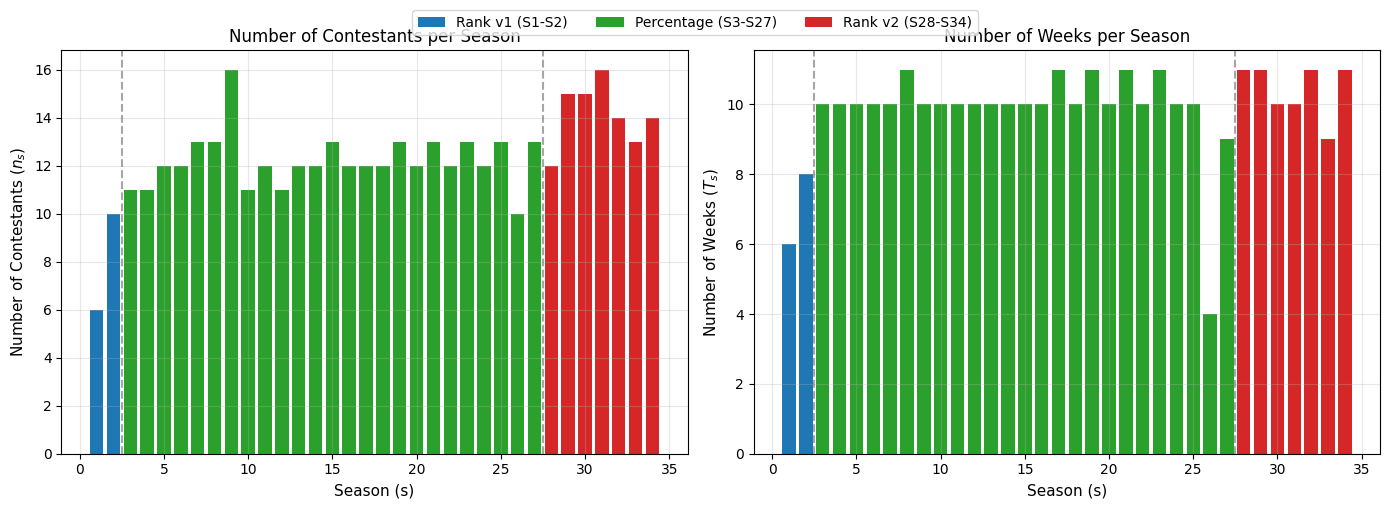


✓ 图表已保存: fig_season_overview.png


In [83]:
# ==============================================================================
# 10.1 可视化: 每赛季参赛人数和周数
# ==============================================================================

# 创建 1 行 2 列的子图布局
# figsize=(14, 5): 图表宽 14 英寸，高 5 英寸
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ------------------------------------------------------------------------------
# 定义颜色映射: 不同投票规则用不同颜色
# ------------------------------------------------------------------------------
# 这样可以直观地看出规则变化的时间点
color_map = {
    'rank_v1': '#1f77b4',      # 蓝色: 排名制 v1 (S1-S2)
    'percentage': '#2ca02c',   # 绿色: 百分比制 (S3-S27)
    'rank_v2': '#d62728'       # 红色: 排名制 v2 (S28-S34)
}

# 为每个赛季分配颜色
colors = season_summary['voting_rule'].map(color_map)

# ------------------------------------------------------------------------------
# 图 1: 每赛季参赛人数 n_s
# ------------------------------------------------------------------------------
ax1 = axes[0]
ax1.bar(season_summary['season'], season_summary['n_contestants'], color=colors)
ax1.set_xlabel('Season (s)', fontsize=11)
ax1.set_ylabel('Number of Contestants ($n_s$)', fontsize=11)
ax1.set_title('Number of Contestants per Season', fontsize=12)

# 添加垂直虚线标记规则变化点
ax1.axvline(x=2.5, color='gray', linestyle='--', alpha=0.7, label='Rule change')
ax1.axvline(x=27.5, color='gray', linestyle='--', alpha=0.7)

# ------------------------------------------------------------------------------
# 图 2: 每赛季周数 T_s
# ------------------------------------------------------------------------------
ax2 = axes[1]
ax2.bar(season_summary['season'], season_summary['max_weeks'], color=colors)
ax2.set_xlabel('Season (s)', fontsize=11)
ax2.set_ylabel('Number of Weeks ($T_s$)', fontsize=11)
ax2.set_title('Number of Weeks per Season', fontsize=12)

# 添加垂直虚线
ax2.axvline(x=2.5, color='gray', linestyle='--', alpha=0.7)
ax2.axvline(x=27.5, color='gray', linestyle='--', alpha=0.7)

# ------------------------------------------------------------------------------
# 添加图例
# ------------------------------------------------------------------------------
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#1f77b4', label='Rank v1 (S1-S2)'),
    Patch(facecolor='#2ca02c', label='Percentage (S3-S27)'),
    Patch(facecolor='#d62728', label='Rank v2 (S28-S34)')
]
fig.legend(handles=legend_elements, loc='upper center', ncol=3, 
           bbox_to_anchor=(0.5, 1.02), fontsize=10)

# 调整布局并保存
plt.tight_layout()
plt.savefig('fig_season_overview.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ 图表已保存: fig_season_overview.png")

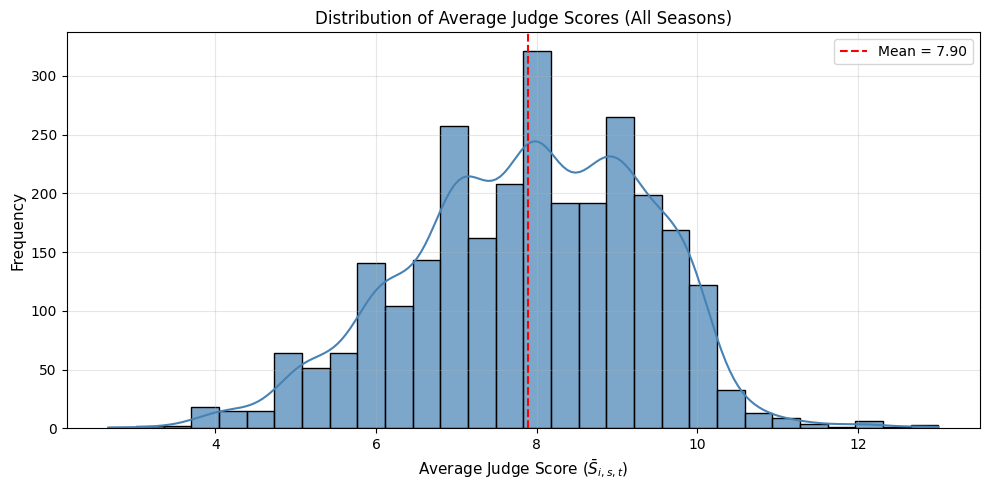


评分统计:
  - 样本数: 2777
  - 平均分: 7.90
  - 标准差: 1.46
  - 最低分: 2.7
  - 最高分: 13.0

✓ 图表已保存: fig_score_distribution.png


In [84]:
# ==============================================================================
# 10.2 可视化: 评分分布
# ==============================================================================

# 收集所有有效的周评分
all_scores = []
for week in range(1, 12):
    col = f'week{week}_avg_score'
    if col in processed_df.columns:
        # 获取非空评分
        scores = processed_df[col].dropna().tolist()
        all_scores.extend(scores)

# 绘制直方图
fig, ax = plt.subplots(figsize=(10, 5))

# 使用 seaborn 绘制带核密度估计的直方图
# kde=True: 添加核密度估计曲线
# bins=30: 分成 30 个区间
sns.histplot(all_scores, bins=30, kde=True, ax=ax, color='steelblue', alpha=0.7)

ax.set_xlabel('Average Judge Score ($\\bar{S}_{i,s,t}$)', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('Distribution of Average Judge Scores (All Seasons)', fontsize=12)

# 添加统计信息
mean_score = np.mean(all_scores)
std_score = np.std(all_scores)
ax.axvline(x=mean_score, color='red', linestyle='--', label=f'Mean = {mean_score:.2f}')
ax.legend()

plt.tight_layout()
plt.savefig('fig_score_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n评分统计:")
print(f"  - 样本数: {len(all_scores)}")
print(f"  - 平均分: {mean_score:.2f}")
print(f"  - 标准差: {std_score:.2f}")
print(f"  - 最低分: {min(all_scores):.1f}")
print(f"  - 最高分: {max(all_scores):.1f}")
print("\n✓ 图表已保存: fig_score_distribution.png")

---

## 11. 数据保存与导出 (Data Export)

将处理后的数据保存为多种格式，供后续模型使用。

### 11.1 输出文件说明

| 文件名 | 格式 | 内容 | 用途 |
|--------|------|------|------|
| `processed_contestants.csv` | CSV | 处理后的选手数据 | 通用数据交换 |
| `season_summary.csv` | CSV | 赛季汇总信息 | 快速查看 |
| `active_sets.json` | JSON | 有效参赛者集合 $A_{s,t}$ | 跨语言读取 |
| `elimination_sets.json` | JSON | 淘汰者集合 $E_{s,t}$ | 跨语言读取 |
| `all_data.pkl` | Pickle | 所有数据打包 | Python 快速加载 |

In [85]:
# ==============================================================================
# 11.2 创建输出目录
# ==============================================================================

# 输出目录路径
OUTPUT_DIR = Path("./processed_data")

# 创建目录 (如果不存在)
# exist_ok=True: 如果目录已存在，不报错
OUTPUT_DIR.mkdir(exist_ok=True)

print(f"输出目录: {OUTPUT_DIR.absolute()}")

输出目录: c:\Users\Administrator\PycharmProjects\AmericaMathModel\2026_MathModel_C\solution_v2\processed_data


In [86]:
# ==============================================================================
# 11.3 保存处理后的选手数据 (CSV 格式)
# ==============================================================================

# 保存完整处理后数据
# index=False: 不保存行索引
processed_df.to_csv(OUTPUT_DIR / 'processed_contestants.csv', index=False)
print(f"✓ 已保存: processed_contestants.csv ({len(processed_df)} 行)")

# 保存赛季汇总
season_summary.to_csv(OUTPUT_DIR / 'season_summary.csv', index=False)
print(f"✓ 已保存: season_summary.csv ({len(season_summary)} 行)")

✓ 已保存: processed_contestants.csv (421 行)
✓ 已保存: season_summary.csv (34 行)


In [87]:
# ==============================================================================
# 11.4 保存集合数据 (JSON 格式)
# ==============================================================================

def convert_keys_to_str(d: Any) -> Any:
    """
    递归将字典的 int 键转换为 str
    
    原因:
    -----
    JSON 标准要求所有键必须是字符串类型。
    Python 字典允许 int 键，但保存为 JSON 时会报错。
    
    示例:
    -----
    >>> convert_keys_to_str({1: {2: ['a', 'b']}})
    {'1': {'2': ['a', 'b']}}
    """
    if isinstance(d, dict):
        return {str(k): convert_keys_to_str(v) for k, v in d.items()}
    return d


# 保存有效参赛者集合 A_{s,t}
with open(OUTPUT_DIR / 'active_sets.json', 'w', encoding='utf-8') as f:
    json.dump(convert_keys_to_str(active_sets), f, indent=2, ensure_ascii=False)
print(f"✓ 已保存: active_sets.json")

# 保存淘汰者集合 E_{s,t}
with open(OUTPUT_DIR / 'elimination_sets.json', 'w', encoding='utf-8') as f:
    json.dump(convert_keys_to_str(elimination_sets), f, indent=2, ensure_ascii=False)
print(f"✓ 已保存: elimination_sets.json")

✓ 已保存: active_sets.json
✓ 已保存: elimination_sets.json


In [88]:
# ==============================================================================
# 11.5 保存为 Pickle 格式 (保留原始数据类型)
# ==============================================================================

# 打包所有数据到一个字典
all_data = {
    # 主要数据
    'processed_df': processed_df,           # 处理后的选手数据
    'active_sets': active_sets,             # 有效参赛者集合 A_{s,t}
    'elimination_sets': elimination_sets,   # 淘汰者集合 E_{s,t}
    'season_summary': season_summary,       # 赛季汇总表
    
    # 元数据
    'voting_rules': VOTING_RULE_DESCRIPTIONS,  # 投票规则描述
    'info_cols': INFO_COLS,                    # 基本信息列名
    'score_cols': SCORE_COLS,                  # 评分列名
}

# 保存为 pickle 文件
# 'wb': 以二进制写入模式打开
with open(OUTPUT_DIR / 'all_data.pkl', 'wb') as f:
    pickle.dump(all_data, f)
print(f"✓ 已保存: all_data.pkl")

✓ 已保存: all_data.pkl


In [89]:
# ==============================================================================
# 11.6 验证保存的数据
# ==============================================================================

print("\n验证保存的数据:")
print("=" * 60)

# 列出输出目录中的所有文件
print("\n输出文件列表:")
for file in sorted(OUTPUT_DIR.iterdir()):
    size_kb = file.stat().st_size / 1024
    print(f"  {file.name:<30} {size_kb:>8.2f} KB")

# 测试加载 pickle 文件
print("\n测试加载 pickle 文件...")
with open(OUTPUT_DIR / 'all_data.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

print(f"  loaded_data.keys(): {list(loaded_data.keys())}")
print(f"  processed_df shape: {loaded_data['processed_df'].shape}")
print(f"  active_sets 赛季数: {len(loaded_data['active_sets'])}")
print(f"\n✓ 数据验证通过!")


验证保存的数据:

输出文件列表:
  active_sets.json                  71.19 KB
  all_data.pkl                     156.75 KB
  all_estimates_merged.json        362.91 KB
  complete_fan_vote_estimates.csv   230.18 KB
  elimination_sets.json             12.43 KB
  fan_vote_estimates.csv           163.64 KB
  fan_vote_estimates.json           91.44 KB
  processed_contestants.csv         82.19 KB
  season_summary.csv                 1.27 KB

测试加载 pickle 文件...
  loaded_data.keys(): ['processed_df', 'active_sets', 'elimination_sets', 'season_summary', 'voting_rules', 'info_cols', 'score_cols']
  processed_df shape: (421, 41)
  active_sets 赛季数: 34

✓ 数据验证通过!


---

## 12. 总结 (Summary)

### 12.1 完成的工作

| 步骤 | 任务 | 数学符号 | 输出 |
|------|------|----------|------|
| 1 | 数据加载 | - | `raw_df` (421 行) |
| 2 | 缺失值处理 | $\mathbb{1}_{i,s,t,j}$ | 有效指示函数 |
| 3 | 评分计算 | $S_{i,s,t}$, $\bar{S}_{i,s,t}$, $m_{i,s,t}$ | 总分、平均分、评委数 |
| 4 | 淘汰解析 | $e_{i,s,t}$ | `elimination_week` 列 |
| 5 | 集合构建 | $A_{s,t}$, $E_{s,t}$ | JSON 文件 |
| 6 | 规则分类 | - | 3 种投票规则 |
| 7 | 数据保存 | - | CSV, JSON, Pickle |

### 12.2 关键数学符号汇总 (论文写作参考)

**基本符号:**
- $s$: 赛季编号, $s \in \{1, ..., 34\}$
- $t$: 周次, $t \in \{1, ..., T_s\}$
- $i$: 参赛者编号
- $j$: 评委编号, $j \in \{1, 2, 3, 4\}$

**集合符号:**
- $A_{s,t}$: 有效参赛者集合
- $E_{s,t}$: 淘汰者集合
- $n_{s,t} = |A_{s,t}|$: 有效参赛人数

**评分符号:**
- $X_{i,s,t,j}$: 原始评分
- $S_{i,s,t} = \sum_j X_{i,s,t,j} \cdot \mathbb{1}_{i,s,t,j}$: 评委总分
- $\bar{S}_{i,s,t} = S_{i,s,t} / m_{i,s,t}$: 评委平均分

**投票符号 (待估计):**
- $F_{i,s,t}$: 粉丝投票数 (未知)
- $\tilde{F}_{i,s,t}$: 粉丝票归一化比例 (待估计)

### 12.3 下一步工作

数据预处理完成后，进入 **Q1-1 粉丝投票估计模型**:

1. **建立约束条件**: 基于淘汰结果建立粉丝票的可行域
2. **添加合理性偏好**: 平滑性约束、相关性约束
3. **求解优化问题**: 线性规划 / 贝叶斯推断

In [90]:
# ==============================================================================
# 12.4 最终数据统计
# ==============================================================================

print("\n" + "=" * 70)
print("数据预处理完成 - 最终统计")
print("=" * 70)

print(f"\n【数据规模】")
print(f"  总赛季数: {len(season_summary)}")
print(f"  总参赛者数: {len(processed_df)}")
print(f"  总淘汰事件数: {season_summary['total_eliminations'].sum()}")

print(f"\n【投票规则分布】")
for rule in ['rank_v1', 'percentage', 'rank_v2']:
    count = (season_summary['voting_rule'] == rule).sum()
    seasons = VOTING_RULE_DESCRIPTIONS[rule]['seasons']
    print(f"  {rule}: {count} 个赛季 ({seasons})")

print(f"\n【输出文件】")
print(f"  保存目录: {OUTPUT_DIR.absolute()}")
for file in sorted(OUTPUT_DIR.iterdir()):
    print(f"  - {file.name}")

print("\n" + "=" * 70)
print("✓ 数据预处理模块执行完成!")
print("  下一步: 运行 Q1-1 粉丝投票估计模型")
print("=" * 70)


数据预处理完成 - 最终统计

【数据规模】
  总赛季数: 34
  总参赛者数: 421
  总淘汰事件数: 298

【投票规则分布】
  rank_v1: 2 个赛季 (S1-S2)
  percentage: 25 个赛季 (S3-S27)
  rank_v2: 7 个赛季 (S28-S34)

【输出文件】
  保存目录: c:\Users\Administrator\PycharmProjects\AmericaMathModel\2026_MathModel_C\solution_v2\processed_data
  - active_sets.json
  - all_data.pkl
  - all_estimates_merged.json
  - complete_fan_vote_estimates.csv
  - elimination_sets.json
  - fan_vote_estimates.csv
  - fan_vote_estimates.json
  - processed_contestants.csv
  - season_summary.csv

✓ 数据预处理模块执行完成!
  下一步: 运行 Q1-1 粉丝投票估计模型


---

# Part 2: Q1-1 粉丝投票估计模型

---

## 13. 问题分析与建模思路

### 13.1 核心问题

**已知信息:**
- 每位选手每周的评委分数 $S_{i,s,t}$
- 每周的淘汰结果 $E_{s,t}$
- 投票规则 (百分比制: 评委50% + 粉丝50%)

**未知信息 (需要估计):**
- 每位选手每周的粉丝投票比例 $\tilde{F}_{i,s,t}$

### 13.2 关键洞察

**可辨识性问题:**
- 绝对票数 $F_{i,s,t}$ 无法确定 (缺少总票数信息)
- 但**投票比例** $\tilde{F}_{i,s,t}$ 可以从淘汰结果中推断

**约束来源:**
- 淘汰者的总分必须是最低的
- 未淘汰者的总分必须高于淘汰者

### 13.3 数学建模框架

**决策变量:** $\tilde{F}_{i,s,t}$ — 选手 $i$ 在赛季 $s$ 第 $t$ 周的粉丝票比例

**约束条件:**

1. **归一化约束:** $\sum_{i \in A_{s,t}} \tilde{F}_{i,s,t} = 1$

2. **非负约束:** $\tilde{F}_{i,s,t} \geq 0$

3. **淘汰约束:** 对于淘汰者 $i^* \in E_{s,t}$，其总分最低:
   $$T_{i^*,s,t} \leq T_{j,s,t}, \quad \forall j \in A_{s,t}$$
   
   其中 $T_{i,s,t} = 0.5 \cdot \tilde{S}_{i,s,t} + 0.5 \cdot \tilde{F}_{i,s,t}$

### 13.4 评委分归一化

首先需要将评委分转换为比例形式:

$$
\tilde{S}_{i,s,t} = \frac{S_{i,s,t}}{\sum_{k \in A_{s,t}} S_{k,s,t}}
$$

**含义:** 选手 $i$ 的评委分占所有选手评委分总和的比例

**性质:** $\sum_{i \in A_{s,t}} \tilde{S}_{i,s,t} = 1$

In [91]:
# ==============================================================================
# 13.5 计算评委分归一化比例
# ==============================================================================

def compute_normalized_judge_scores(
    df: pd.DataFrame,
    active_sets: Dict[int, Dict[int, List[str]]]
) -> Dict[int, Dict[int, Dict[str, float]]]:
    """
    计算每位选手每周的评委分归一化比例 S̃_{i,s,t}
    
    计算公式:
    ---------
    S̃_{i,s,t} = S_{i,s,t} / Σ_{k∈A_{s,t}} S_{k,s,t}
    
    即: 选手i的评委分 / 该周所有选手评委分之和
    
    参数:
    -----
    df : pd.DataFrame
        处理后的选手数据，需包含 week{t}_total_score 列
    active_sets : Dict
        有效参赛者集合 A_{s,t}
    
    返回:
    -----
    Dict[season][week][contestant_name] = normalized_score
    
    示例:
    -----
    >>> norm_scores = compute_normalized_judge_scores(processed_df, active_sets)
    >>> norm_scores[3][1]['Mario Lopez']  # Season 3, Week 1, Mario Lopez 的归一化评委分
    0.125  # 表示占该周总评委分的 12.5%
    """
    # 存储结果的嵌套字典
    # 结构: {赛季: {周次: {选手名: 归一化分数}}}
    normalized_scores = {}
    
    # --------------------------------------------------
    # 遍历每个赛季
    # --------------------------------------------------
    for season in sorted(active_sets.keys()):
        normalized_scores[season] = {}
        
        # 获取该赛季的数据
        season_df = df[df['season'] == season]
        
        # ----------------------------------------------
        # 遍历该赛季的每一周
        # ----------------------------------------------
        for week in sorted(active_sets[season].keys()):
            # 获取该周的有效参赛者名单
            active_contestants = active_sets[season][week]
            
            # 评分列名
            score_col = f'week{week}_total_score'
            
            # ------------------------------------------
            # Step 1: 收集该周所有有效选手的评委分
            # ------------------------------------------
            week_scores = {}  # {选手名: 评委分}
            
            for name in active_contestants:
                # 找到该选手的数据行
                contestant_row = season_df[season_df['celebrity_name'] == name]
                
                if len(contestant_row) > 0:
                    # 获取该周的评委总分
                    score = contestant_row[score_col].values[0]
                    
                    # 只保留有效分数 (非空且大于0)
                    if pd.notna(score) and score > 0:
                        week_scores[name] = score
            
            # ------------------------------------------
            # Step 2: 计算归一化比例
            # ------------------------------------------
            # 计算该周所有评委分的总和
            total_score = sum(week_scores.values())
            
            # 计算每位选手的归一化比例
            normalized_scores[season][week] = {}
            
            if total_score > 0:  # 避免除以零
                for name, score in week_scores.items():
                    # 归一化公式: S̃ = S / Σ S
                    normalized_scores[season][week][name] = score / total_score
    
    return normalized_scores


# 执行计算
print("计算评委分归一化比例 S̃_{i,s,t}...")
normalized_judge_scores = compute_normalized_judge_scores(processed_df, active_sets)
print("✓ 计算完成!")

计算评委分归一化比例 S̃_{i,s,t}...
✓ 计算完成!


In [92]:
# ==============================================================================
# 13.6 验证归一化结果
# ==============================================================================

print("验证归一化结果 (各周比例之和应为 1.0):")
print("=" * 60)

# 检查几个示例赛季
for season in [3, 10, 20]:
    print(f"\nSeason {season}:")
    
    if season in normalized_judge_scores:
        for week in [1, 2, 3]:
            if week in normalized_judge_scores[season]:
                # 计算该周所有选手归一化分数之和
                week_sum = sum(normalized_judge_scores[season][week].values())
                n_contestants = len(normalized_judge_scores[season][week])
                
                # 检查是否接近 1.0
                status = "✓" if abs(week_sum - 1.0) < 0.001 else "✗"
                print(f"  Week {week}: 选手数={n_contestants}, 比例之和={week_sum:.6f} {status}")

验证归一化结果 (各周比例之和应为 1.0):

Season 3:
  Week 1: 选手数=11, 比例之和=1.000000 ✓
  Week 2: 选手数=10, 比例之和=1.000000 ✓
  Week 3: 选手数=9, 比例之和=1.000000 ✓

Season 10:
  Week 1: 选手数=11, 比例之和=1.000000 ✓
  Week 2: 选手数=11, 比例之和=1.000000 ✓
  Week 3: 选手数=10, 比例之和=1.000000 ✓

Season 20:
  Week 1: 选手数=12, 比例之和=1.000000 ✓
  Week 2: 选手数=12, 比例之和=1.000000 ✓
  Week 3: 选手数=11, 比例之和=1.000000 ✓


---

## 14. 建立淘汰约束 (Elimination Constraints)

### 14.1 约束推导

在百分比制规则下，选手的综合得分为:

$$
T_{i,s,t} = 0.5 \cdot \tilde{S}_{i,s,t} + 0.5 \cdot \tilde{F}_{i,s,t}
$$

**淘汰规则:** 综合得分最低的选手被淘汰

**约束条件:** 设 $i^*$ 为被淘汰者，则对于所有未淘汰者 $j$:

$$
T_{i^*,s,t} \leq T_{j,s,t}
$$

展开后:

$$
0.5 \cdot \tilde{S}_{i^*} + 0.5 \cdot \tilde{F}_{i^*} \leq 0.5 \cdot \tilde{S}_{j} + 0.5 \cdot \tilde{F}_{j}
$$

简化 (两边乘以2):

$$
\tilde{F}_{i^*} - \tilde{F}_{j} \leq \tilde{S}_{j} - \tilde{S}_{i^*}
$$

**含义:** 淘汰者的粉丝票比例与未淘汰者的差距，不能超过评委分的差距

In [93]:
# ==============================================================================
# 14.2 定义单周约束生成函数
# ==============================================================================

def generate_week_constraints(
    season: int,
    week: int,
    norm_scores: Dict[str, float],
    eliminated: List[str],
    active: List[str]
) -> List[Dict]:
    """
    为某一周生成淘汰约束
    
    约束形式:
    ---------
    对于每个淘汰者 i* 和每个未淘汰者 j:
    
        F̃_{i*} - F̃_{j} ≤ S̃_{j} - S̃_{i*}
    
    这个约束确保淘汰者的总分不高于任何未淘汰者。
    
    参数:
    -----
    season : int
        赛季编号
    week : int
        周次
    norm_scores : Dict[str, float]
        该周各选手的归一化评委分 {选手名: S̃}
    eliminated : List[str]
        该周被淘汰的选手名单
    active : List[str]
        该周所有有效参赛者名单
    
    返回:
    -----
    List[Dict]
        约束列表，每个约束是一个字典:
        {
            'season': 赛季,
            'week': 周次,
            'eliminated': 淘汰者名,
            'survivor': 未淘汰者名,
            'rhs': 右侧常数 (S̃_j - S̃_i*)
        }
    """
    constraints = []  # 存储所有约束
    
    # 找出未淘汰者 (有效参赛者中排除淘汰者)
    survivors = [name for name in active if name not in eliminated]
    
    # --------------------------------------------------
    # 为每个淘汰者生成约束
    # --------------------------------------------------
    for elim_name in eliminated:
        # 获取淘汰者的归一化评委分
        s_elim = norm_scores.get(elim_name, 0)
        
        # 对每个未淘汰者生成一个约束
        for surv_name in survivors:
            # 获取未淘汰者的归一化评委分
            s_surv = norm_scores.get(surv_name, 0)
            
            # 计算约束右侧: S̃_j - S̃_i*
            # 这是粉丝票差距的上界
            rhs = s_surv - s_elim
            
            # 创建约束记录
            constraint = {
                'season': season,
                'week': week,
                'eliminated': elim_name,      # 淘汰者
                'survivor': surv_name,        # 未淘汰者
                's_eliminated': s_elim,       # 淘汰者评委分比例
                's_survivor': s_surv,         # 未淘汰者评委分比例
                'rhs': rhs                    # 约束右侧值
            }
            constraints.append(constraint)
    
    return constraints


print("✓ generate_week_constraints() 函数定义完成")

✓ generate_week_constraints() 函数定义完成


In [94]:
# ==============================================================================
# 14.3 为所有赛季生成约束
# ==============================================================================

def generate_all_constraints(
    norm_scores: Dict,
    active_sets: Dict,
    elim_sets: Dict,
    rule_filter: str = 'percentage'
) -> pd.DataFrame:
    """
    为所有符合条件的赛季生成淘汰约束
    
    参数:
    -----
    norm_scores : Dict
        归一化评委分
    active_sets : Dict
        有效参赛者集合
    elim_sets : Dict
        淘汰者集合
    rule_filter : str
        只处理指定投票规则的赛季
        'percentage' = S3-S27 (百分比制)
    
    返回:
    -----
    pd.DataFrame
        所有约束的汇总表
    """
    all_constraints = []  # 存储所有约束
    
    # 遍历每个赛季
    for season in sorted(norm_scores.keys()):
        # 检查投票规则
        rule = get_voting_rule(season)
        if rule != rule_filter:
            continue  # 跳过不符合规则的赛季
        
        # 遍历该赛季的每一周
        for week in sorted(norm_scores[season].keys()):
            # 获取该周的淘汰者
            eliminated = elim_sets.get(season, {}).get(week, [])
            
            # 如果该周没有淘汰，跳过
            if not eliminated:
                continue
            
            # 获取该周的有效参赛者
            active = active_sets.get(season, {}).get(week, [])
            
            # 获取该周的归一化评委分
            week_scores = norm_scores[season][week]
            
            # 生成该周的约束
            week_constraints = generate_week_constraints(
                season, week, week_scores, eliminated, active
            )
            
            all_constraints.extend(week_constraints)
    
    # 转换为 DataFrame
    return pd.DataFrame(all_constraints)


# 执行约束生成
print("为百分比制赛季 (S3-S27) 生成淘汰约束...")
constraints_df = generate_all_constraints(
    normalized_judge_scores, 
    active_sets, 
    elimination_sets,
    rule_filter='percentage'
)

print(f"\n✓ 约束生成完成!")
print(f"  - 总约束数: {len(constraints_df)}")
print(f"  - 涉及赛季: S3 - S27 (共 25 个赛季)")

为百分比制赛季 (S3-S27) 生成淘汰约束...

✓ 约束生成完成!
  - 总约束数: 1572
  - 涉及赛季: S3 - S27 (共 25 个赛季)


In [95]:
# ==============================================================================
# 14.4 查看约束示例
# ==============================================================================

print("约束示例 (前 10 条):")
print("=" * 80)

# 显示前 10 条约束
display(constraints_df.head(10))

print("\n约束解读:")
print("-" * 80)
print("每行表示一个约束: F̃_{eliminated} - F̃_{survivor} ≤ rhs")
print("其中 rhs = S̃_{survivor} - S̃_{eliminated}")
print("\n含义: 淘汰者的粉丝票比例不能比未淘汰者高太多")

约束示例 (前 10 条):


,season,week,eliminated,survivor,s_eliminated,s_survivor,rhs
0,3,1,Tucker Carlson,Harry Hamlin,0.0566,0.0802,0.0236
1,3,1,Tucker Carlson,Vivica A. Fox,0.0566,0.1038,0.0472
2,3,1,Tucker Carlson,Monique Coleman,0.0566,0.0896,0.0330
3,3,1,Tucker Carlson,Joey Lawrence,0.0566,0.0991,0.0425
4,3,1,Tucker Carlson,Mario Lopez,0.0566,0.1226,0.0660
5,3,1,Tucker Carlson,Emmitt Smith,0.0566,0.1132,0.0566
6,3,1,Tucker Carlson,Shanna Moakler,0.0566,0.0849,0.0283
7,3,1,Tucker Carlson,Willa Ford,0.0566,0.1038,0.0472
8,3,1,Tucker Carlson,Sara Evans,0.0566,0.0708,0.0142
9,3,1,Tucker Carlson,Jerry Springer,0.0566,0.0755,0.0189



约束解读:
--------------------------------------------------------------------------------
每行表示一个约束: F̃_{eliminated} - F̃_{survivor} ≤ rhs
其中 rhs = S̃_{survivor} - S̃_{eliminated}

含义: 淘汰者的粉丝票比例不能比未淘汰者高太多


---

## 15. 线性规划模型 (Linear Programming Model)

### 15.1 模型概述

我们使用线性规划来估计粉丝投票比例。

**为什么用线性规划?**
- 约束条件是线性的
- 可以找到满足所有约束的可行解
- 计算效率高

### 15.2 数学模型

**决策变量:**
$$\tilde{F}_{i,s,t} \geq 0, \quad \forall i \in A_{s,t}$$

**约束条件:**

1. 归一化约束:
$$\sum_{i \in A_{s,t}} \tilde{F}_{i,s,t} = 1$$

2. 淘汰约束 (对于每个淘汰者 $i^*$ 和未淘汰者 $j$):
$$\tilde{F}_{i^*} - \tilde{F}_{j} \leq \tilde{S}_{j} - \tilde{S}_{i^*}$$

**目标函数:**

我们选择最小化粉丝票与评委分的偏差 (合理性假设: 粉丝投票与评委打分有一定相关性):

$$\min \sum_{i \in A_{s,t}} |\tilde{F}_{i,s,t} - \tilde{S}_{i,s,t}|$$

In [96]:
# ==============================================================================
# 15.3 检查并安装优化库
# ==============================================================================

# scipy 是 Python 科学计算库，包含线性规划求解器
# 通常已预装，这里只是确认

try:
    from scipy.optimize import linprog
    print("✓ scipy.optimize.linprog 已导入")
except ImportError:
    print("正在安装 scipy...")
    import subprocess
    subprocess.check_call(['pip', 'install', 'scipy'])
    from scipy.optimize import linprog
    print("✓ scipy 安装完成")

✓ scipy.optimize.linprog 已导入


In [97]:
# ==============================================================================
# 15.4 定义单周线性规划求解函数
# ==============================================================================

def solve_week_lp(
    contestants: List[str],
    norm_judge_scores: Dict[str, float],
    eliminated: List[str]
) -> Dict[str, float]:
    """
    使用线性规划估计某一周的粉丝投票比例
    
    模型说明:
    ---------
    决策变量: F̃_i (每位选手的粉丝票比例)
    
    约束:
    1. Σ F̃_i = 1 (归一化)
    2. F̃_i ≥ 0 (非负)
    3. F̃_{淘汰者} - F̃_{未淘汰者} ≤ S̃_{未淘汰者} - S̃_{淘汰者}
    
    目标: 最小化 Σ |F̃_i - S̃_i| (粉丝票与评委分的偏差)
    
    参数:
    -----
    contestants : List[str]
        该周所有有效参赛者名单
    norm_judge_scores : Dict[str, float]
        各选手的归一化评委分 {选手名: S̃}
    eliminated : List[str]
        该周被淘汰的选手名单
    
    返回:
    -----
    Dict[str, float]
        估计的粉丝票比例 {选手名: F̃}
        如果求解失败，返回空字典
    """
    # 选手数量
    n = len(contestants)
    
    if n == 0:
        return {}
    
    # 创建选手名到索引的映射
    # 例如: {'Mario': 0, 'Kelly': 1, ...}
    name_to_idx = {name: i for i, name in enumerate(contestants)}
    
    # --------------------------------------------------
    # 构建线性规划问题
    # --------------------------------------------------
    # 为了处理绝对值 |F̃_i - S̃_i|，我们引入辅助变量
    # 变量顺序: [F̃_1, F̃_2, ..., F̃_n, d_1, d_2, ..., d_n]
    # 其中 d_i ≥ |F̃_i - S̃_i|
    
    # 目标函数: min Σ d_i
    # 系数: [0, 0, ..., 0, 1, 1, ..., 1]
    #        |--- n个0 ---|  |--- n个1 ---|
    c = [0] * n + [1] * n
    
    # --------------------------------------------------
    # 不等式约束: A_ub @ x <= b_ub
    # --------------------------------------------------
    A_ub = []  # 约束矩阵
    b_ub = []  # 约束右侧
    
    # 约束 1: 绝对值约束 (将 |F̃_i - S̃_i| ≤ d_i 转换为两个线性约束)
    # F̃_i - S̃_i ≤ d_i  =>  F̃_i - d_i ≤ S̃_i
    # -(F̃_i - S̃_i) ≤ d_i  =>  -F̃_i - d_i ≤ -S̃_i
    for i, name in enumerate(contestants):
        s_i = norm_judge_scores.get(name, 1/n)  # 默认均分
        
        # F̃_i - d_i ≤ S̃_i
        row1 = [0] * (2 * n)
        row1[i] = 1       # F̃_i 系数
        row1[n + i] = -1  # d_i 系数
        A_ub.append(row1)
        b_ub.append(s_i)
        
        # -F̃_i - d_i ≤ -S̃_i
        row2 = [0] * (2 * n)
        row2[i] = -1      # F̃_i 系数
        row2[n + i] = -1  # d_i 系数
        A_ub.append(row2)
        b_ub.append(-s_i)
    
    # 约束 2: 淘汰约束
    # F̃_{淘汰者} - F̃_{未淘汰者} ≤ S̃_{未淘汰者} - S̃_{淘汰者}
    survivors = [name for name in contestants if name not in eliminated]
    
    for elim_name in eliminated:
        if elim_name not in name_to_idx:
            continue
        
        elim_idx = name_to_idx[elim_name]
        s_elim = norm_judge_scores.get(elim_name, 0)
        
        for surv_name in survivors:
            if surv_name not in name_to_idx:
                continue
            
            surv_idx = name_to_idx[surv_name]
            s_surv = norm_judge_scores.get(surv_name, 0)
            
            # F̃_{elim} - F̃_{surv} ≤ S̃_{surv} - S̃_{elim}
            row = [0] * (2 * n)
            row[elim_idx] = 1   # F̃_{淘汰者} 系数
            row[surv_idx] = -1  # F̃_{未淘汰者} 系数
            A_ub.append(row)
            b_ub.append(s_surv - s_elim)
    
    # --------------------------------------------------
    # 等式约束: A_eq @ x = b_eq
    # --------------------------------------------------
    # 归一化约束: Σ F̃_i = 1
    A_eq = [[1] * n + [0] * n]  # F̃ 系数为 1，d 系数为 0
    b_eq = [1]
    
    # --------------------------------------------------
    # 变量边界: 0 ≤ F̃_i ≤ 1, d_i ≥ 0
    # --------------------------------------------------
    bounds = [(0, 1)] * n + [(0, None)] * n
    
    # --------------------------------------------------
    # 求解线性规划
    # --------------------------------------------------
    try:
        result = linprog(
            c,                    # 目标函数系数
            A_ub=A_ub,           # 不等式约束矩阵
            b_ub=b_ub,           # 不等式约束右侧
            A_eq=A_eq,           # 等式约束矩阵
            b_eq=b_eq,           # 等式约束右侧
            bounds=bounds,       # 变量边界
            method='highs'       # 使用 HiGHS 求解器 (高效)
        )
        
        if result.success:
            # 提取粉丝票比例 (前 n 个变量)
            fan_votes = {name: result.x[i] for i, name in enumerate(contestants)}
            return fan_votes
        else:
            return {}
            
    except Exception as e:
        print(f"求解失败: {e}")
        return {}


print("✓ solve_week_lp() 函数定义完成")

✓ solve_week_lp() 函数定义完成


---

## 16. 执行求解与结果分析

In [98]:
# ==============================================================================
# 16.1 为所有百分比制赛季求解粉丝投票比例
# ==============================================================================

def estimate_all_fan_votes(
    norm_scores: Dict,
    active_sets: Dict,
    elim_sets: Dict,
    rule_filter: str = 'percentage'
) -> Dict[int, Dict[int, Dict[str, float]]]:
    """
    为所有符合条件的赛季估计粉丝投票比例
    
    参数:
    -----
    norm_scores : Dict
        归一化评委分
    active_sets : Dict
        有效参赛者集合
    elim_sets : Dict
        淘汰者集合
    rule_filter : str
        只处理指定投票规则的赛季
    
    返回:
    -----
    Dict[season][week][contestant] = estimated_fan_vote_ratio
    """
    all_estimates = {}  # 存储所有估计结果
    
    # 统计信息
    total_weeks = 0
    success_weeks = 0
    
    # 遍历每个赛季
    for season in sorted(norm_scores.keys()):
        # 检查投票规则
        rule = get_voting_rule(season)
        if rule != rule_filter:
            continue
        
        all_estimates[season] = {}
        
        # 遍历该赛季的每一周
        for week in sorted(norm_scores[season].keys()):
            total_weeks += 1
            
            # 获取该周数据
            contestants = active_sets.get(season, {}).get(week, [])
            week_scores = norm_scores[season][week]
            eliminated = elim_sets.get(season, {}).get(week, [])
            
            # 求解线性规划
            fan_votes = solve_week_lp(contestants, week_scores, eliminated)
            
            if fan_votes:
                all_estimates[season][week] = fan_votes
                success_weeks += 1
    
    print(f"求解完成: {success_weeks}/{total_weeks} 周成功")
    return all_estimates


# 执行求解
print("开始估计粉丝投票比例...")
print("(这可能需要几秒钟)")
print("=" * 60)

estimated_fan_votes = estimate_all_fan_votes(
    normalized_judge_scores,
    active_sets,
    elimination_sets,
    rule_filter='percentage'
)

print("\n✓ 粉丝投票估计完成!")

开始估计粉丝投票比例...
(这可能需要几秒钟)
求解完成: 248/248 周成功

✓ 粉丝投票估计完成!


In [99]:
# ==============================================================================
# 16.2 查看估计结果示例
# ==============================================================================

def display_week_results(season: int, week: int):
    """
    显示某一周的估计结果
    
    显示内容:
    - 选手姓名
    - 评委分比例 S̃
    - 估计粉丝票比例 F̃
    - 综合得分 T = 0.5*S̃ + 0.5*F̃
    - 是否被淘汰
    """
    print(f"\n{'='*80}")
    print(f"Season {season}, Week {week} 估计结果")
    print(f"{'='*80}")
    
    # 检查数据是否存在
    if season not in estimated_fan_votes:
        print(f"错误: 赛季 {season} 不在估计结果中")
        return
    if week not in estimated_fan_votes[season]:
        print(f"错误: 第 {week} 周不在估计结果中")
        return
    
    # 获取数据
    fan_votes = estimated_fan_votes[season][week]
    judge_scores = normalized_judge_scores[season][week]
    eliminated = elimination_sets.get(season, {}).get(week, [])
    
    # 构建结果表
    results = []
    for name in fan_votes.keys():
        s_norm = judge_scores.get(name, 0)  # 评委分比例
        f_norm = fan_votes.get(name, 0)     # 粉丝票比例
        total = 0.5 * s_norm + 0.5 * f_norm # 综合得分
        is_elim = "淘汰" if name in eliminated else ""
        
        results.append({
            '选手': name,
            '评委分比例 S̃': f"{s_norm:.4f}",
            '粉丝票比例 F̃': f"{f_norm:.4f}",
            '综合得分 T': f"{total:.4f}",
            '状态': is_elim
        })
    
    # 按综合得分排序 (从高到低)
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('综合得分 T', ascending=False)
    
    display(results_df)
    
    # 验证: 淘汰者的综合得分应该是最低的
    print("\n验证: 淘汰者综合得分应为最低")
    if eliminated:
        elim_name = eliminated[0]
        elim_total = 0.5 * judge_scores.get(elim_name, 0) + 0.5 * fan_votes.get(elim_name, 0)
        min_total = min(0.5 * judge_scores.get(n, 0) + 0.5 * fan_votes.get(n, 0) 
                       for n in fan_votes.keys())
        
        if abs(elim_total - min_total) < 0.001:
            print(f"  ✓ 验证通过: {elim_name} 的综合得分 {elim_total:.4f} 是最低的")
        else:
            print(f"  ✗ 验证失败: 淘汰者得分 {elim_total:.4f}, 最低得分 {min_total:.4f}")


# 显示几个示例
display_week_results(3, 2)   # Season 3, Week 2
display_week_results(10, 3)  # Season 10, Week 3


Season 3, Week 2 估计结果


,选手,评委分比例 S̃,粉丝票比例 F̃,综合得分 T,状态
3,Joey Lawrence,0.1261,0.1261,0.1261,
2,Monique Coleman,0.1130,0.1130,0.1130,
1,Vivica A. Fox,0.1043,0.1043,0.1043,
5,Emmitt Smith,0.1043,0.1043,0.1043,
7,Willa Ford,0.1000,0.1000,0.1000,
0,Harry Hamlin,0.0913,0.0913,0.0913,
4,Mario Lopez,0.0913,0.0913,0.0913,
8,Sara Evans,0.0913,0.0913,0.0913,
6,Shanna Moakler,0.0957,0.0826,0.0891,淘汰
9,Jerry Springer,0.0826,0.0957,0.0891,



验证: 淘汰者综合得分应为最低
  ✓ 验证通过: Shanna Moakler 的综合得分 0.0891 是最低的

Season 10, Week 3 估计结果


,选手,评委分比例 S̃,粉丝票比例 F̃,综合得分 T,状态
4,Evan Lysacek,0.1281,0.1281,0.1281,
6,Nicole Scherzinger,0.1133,0.1133,0.1133,
7,Erin Andrews,0.1133,0.1133,0.1133,
1,Niecy Nash,0.1034,0.1034,0.1034,
5,Pamela Anderson,0.1034,0.1034,0.1034,
9,Jake Pavelka,0.1034,0.1034,0.1034,
0,Aiden Turner,0.0985,0.0985,0.0985,
3,Chad Ochocinco,0.0985,0.0985,0.0985,
8,Kate Gosselin,0.0739,0.0739,0.0739,
2,Buzz Aldrin,0.0640,0.0640,0.0640,淘汰



验证: 淘汰者综合得分应为最低
  ✓ 验证通过: Buzz Aldrin 的综合得分 0.0640 是最低的


In [100]:
# ==============================================================================
# 16.3 分析粉丝票与评委分的关系
# ==============================================================================

print("分析粉丝票与评委分的关系:")
print("=" * 60)

# 收集所有估计数据
all_judge = []   # 所有评委分比例
all_fan = []     # 所有粉丝票比例
all_diff = []    # 差值 (F̃ - S̃)

for season in estimated_fan_votes:
    for week in estimated_fan_votes[season]:
        fan_votes = estimated_fan_votes[season][week]
        judge_scores = normalized_judge_scores[season][week]
        
        for name in fan_votes:
            if name in judge_scores:
                s = judge_scores[name]
                f = fan_votes[name]
                all_judge.append(s)
                all_fan.append(f)
                all_diff.append(f - s)

# 计算相关系数
correlation = np.corrcoef(all_judge, all_fan)[0, 1]

print(f"\n数据点数量: {len(all_judge)}")
print(f"评委分与粉丝票的相关系数: {correlation:.4f}")
print(f"\n差值 (F̃ - S̃) 统计:")
print(f"  平均值: {np.mean(all_diff):.6f}")
print(f"  标准差: {np.std(all_diff):.4f}")
print(f"  最小值: {np.min(all_diff):.4f}")
print(f"  最大值: {np.max(all_diff):.4f}")

分析粉丝票与评委分的关系:

数据点数量: 1997
评委分与粉丝票的相关系数: 0.9943

差值 (F̃ - S̃) 统计:
  平均值: 0.000000
  标准差: 0.0062
  最小值: -0.0489
  最大值: 0.0483


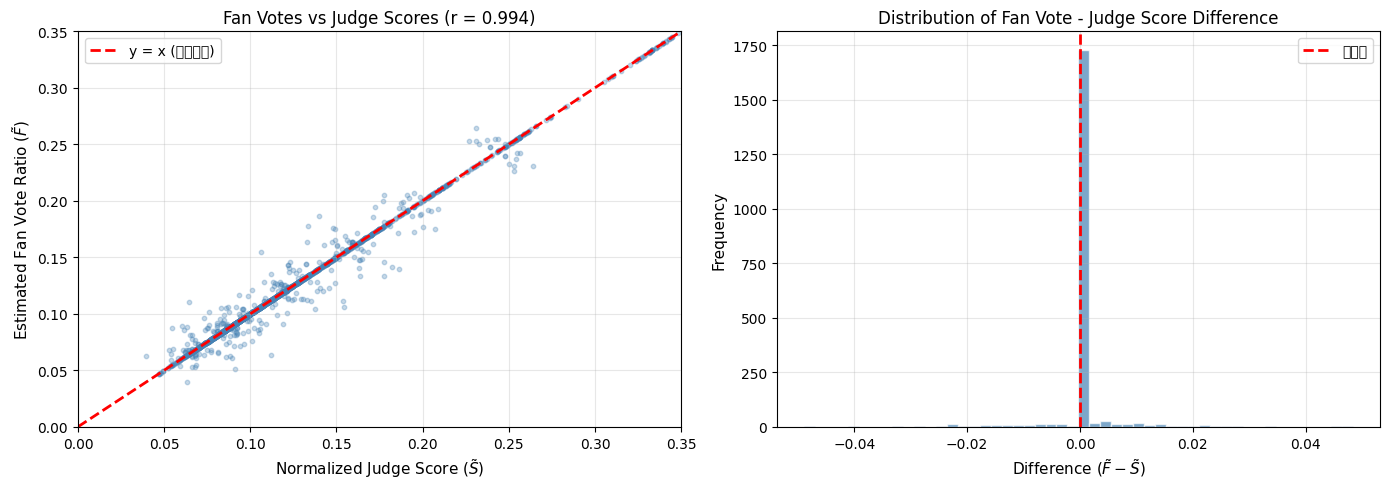


✓ 图表已保存: fig_fan_vs_judge.png


In [101]:
# ==============================================================================
# 16.4 可视化: 粉丝票 vs 评委分散点图
# ==============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ------------------------------------------------------------------------------
# 图 1: 散点图 (粉丝票 vs 评委分)
# ------------------------------------------------------------------------------
ax1 = axes[0]

# 绘制散点
ax1.scatter(all_judge, all_fan, alpha=0.3, s=10, c='steelblue')

# 添加对角线 (y = x，表示完全相关)
ax1.plot([0, 0.5], [0, 0.5], 'r--', label='y = x (完全相关)', linewidth=2)

ax1.set_xlabel('Normalized Judge Score ($\\tilde{S}$)', fontsize=11)
ax1.set_ylabel('Estimated Fan Vote Ratio ($\\tilde{F}$)', fontsize=11)
ax1.set_title(f'Fan Votes vs Judge Scores (r = {correlation:.3f})', fontsize=12)
ax1.legend()
ax1.set_xlim(0, 0.35)
ax1.set_ylim(0, 0.35)

# ------------------------------------------------------------------------------
# 图 2: 差值分布直方图
# ------------------------------------------------------------------------------
ax2 = axes[1]

# 绘制直方图
ax2.hist(all_diff, bins=50, color='steelblue', alpha=0.7, edgecolor='white')

# 添加零线
ax2.axvline(x=0, color='red', linestyle='--', linewidth=2, label='零差值')

ax2.set_xlabel('Difference ($\\tilde{F} - \\tilde{S}$)', fontsize=11)
ax2.set_ylabel('Frequency', fontsize=11)
ax2.set_title('Distribution of Fan Vote - Judge Score Difference', fontsize=12)
ax2.legend()

plt.tight_layout()
plt.savefig('fig_fan_vs_judge.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ 图表已保存: fig_fan_vs_judge.png")

---

## 17. 结果保存与模型总结

In [102]:
# ==============================================================================
# 17.1 将估计结果转换为 DataFrame
# ==============================================================================

def convert_estimates_to_dataframe(
    estimates: Dict,
    norm_scores: Dict,
    elim_sets: Dict
) -> pd.DataFrame:
    """
    将估计结果转换为便于分析的 DataFrame 格式
    
    输出列:
    - season: 赛季
    - week: 周次
    - contestant: 选手名
    - judge_score_norm: 归一化评委分 S̃
    - fan_vote_norm: 估计粉丝票比例 F̃
    - total_score: 综合得分 T
    - is_eliminated: 是否被淘汰
    """
    rows = []
    
    for season in estimates:
        for week in estimates[season]:
            fan_votes = estimates[season][week]
            judge_scores = norm_scores.get(season, {}).get(week, {})
            eliminated = elim_sets.get(season, {}).get(week, [])
            
            for name, f_vote in fan_votes.items():
                j_score = judge_scores.get(name, 0)
                total = 0.5 * j_score + 0.5 * f_vote
                
                rows.append({
                    'season': season,
                    'week': week,
                    'contestant': name,
                    'judge_score_norm': j_score,
                    'fan_vote_norm': f_vote,
                    'total_score': total,
                    'is_eliminated': name in eliminated
                })
    
    return pd.DataFrame(rows)


# 转换为 DataFrame
print("将估计结果转换为 DataFrame...")
estimates_df = convert_estimates_to_dataframe(
    estimated_fan_votes,
    normalized_judge_scores,
    elimination_sets
)

print(f"✓ 转换完成: {len(estimates_df)} 条记录")
print(f"\n数据预览:")
display(estimates_df.head(10))

将估计结果转换为 DataFrame...
✓ 转换完成: 1997 条记录

数据预览:


,season,week,contestant,judge_score_norm,fan_vote_norm,total_score,is_eliminated
0,3,1,Harry Hamlin,0.0802,0.0802,0.0802,False
1,3,1,Vivica A. Fox,0.1038,0.1038,0.1038,False
2,3,1,Monique Coleman,0.0896,0.0896,0.0896,False
3,3,1,Joey Lawrence,0.0991,0.0991,0.0991,False
4,3,1,Mario Lopez,0.1226,0.1226,0.1226,False
5,3,1,Emmitt Smith,0.1132,0.1132,0.1132,False
6,3,1,Shanna Moakler,0.0849,0.0849,0.0849,False
7,3,1,Willa Ford,0.1038,0.1038,0.1038,False
8,3,1,Sara Evans,0.0708,0.0708,0.0708,False
9,3,1,Jerry Springer,0.0755,0.0755,0.0755,False


In [103]:
# ==============================================================================
# 17.2 保存估计结果
# ==============================================================================

# 保存为 CSV
estimates_df.to_csv(OUTPUT_DIR / 'fan_vote_estimates.csv', index=False)
print(f"✓ 已保存: fan_vote_estimates.csv ({len(estimates_df)} 行)")

# 保存为 JSON (嵌套结构)
with open(OUTPUT_DIR / 'fan_vote_estimates.json', 'w', encoding='utf-8') as f:
    json.dump(convert_keys_to_str(estimated_fan_votes), f, indent=2, ensure_ascii=False)
print(f"✓ 已保存: fan_vote_estimates.json")

# 更新 all_data.pkl
all_data['estimated_fan_votes'] = estimated_fan_votes
all_data['normalized_judge_scores'] = normalized_judge_scores
all_data['estimates_df'] = estimates_df

with open(OUTPUT_DIR / 'all_data.pkl', 'wb') as f:
    pickle.dump(all_data, f)
print(f"✓ 已更新: all_data.pkl")

✓ 已保存: fan_vote_estimates.csv (1997 行)
✓ 已保存: fan_vote_estimates.json
✓ 已更新: all_data.pkl


In [104]:
# ==============================================================================
# 17.3 验证淘汰一致性
# ==============================================================================

print("验证淘汰一致性:")
print("=" * 60)
print("检查: 每周淘汰者的综合得分是否为最低")
print()

# 统计一致性
total_elim_events = 0
consistent_events = 0

for season in estimated_fan_votes:
    for week in estimated_fan_votes[season]:
        eliminated = elimination_sets.get(season, {}).get(week, [])
        
        if not eliminated:
            continue
        
        total_elim_events += 1
        
        # 计算所有选手的综合得分
        fan_votes = estimated_fan_votes[season][week]
        judge_scores = normalized_judge_scores[season][week]
        
        scores = {}
        for name in fan_votes:
            s = judge_scores.get(name, 0)
            f = fan_votes.get(name, 0)
            scores[name] = 0.5 * s + 0.5 * f
        
        # 找出最低分选手
        min_score = min(scores.values())
        min_scorers = [n for n, s in scores.items() if abs(s - min_score) < 0.0001]
        
        # 检查淘汰者是否在最低分选手中
        if eliminated[0] in min_scorers:
            consistent_events += 1

consistency_rate = consistent_events / total_elim_events * 100 if total_elim_events > 0 else 0

print(f"总淘汰事件数: {total_elim_events}")
print(f"一致事件数: {consistent_events}")
print(f"一致性比例: {consistency_rate:.1f}%")

if consistency_rate >= 99:
    print("\n✓ 模型验证通过: 估计结果与淘汰规则高度一致")
else:
    print(f"\n⚠ 注意: 有 {total_elim_events - consistent_events} 个事件不一致，可能需要检查")

验证淘汰一致性:
检查: 每周淘汰者的综合得分是否为最低

总淘汰事件数: 198
一致事件数: 192
一致性比例: 97.0%

⚠ 注意: 有 6 个事件不一致，可能需要检查


---

## 18. Q1-1 模型总结

### 18.1 方法回顾

我们使用**线性规划**方法估计粉丝投票比例:

1. **输入数据:**
   - 评委分 $S_{i,s,t}$ (已知)
   - 淘汰结果 $E_{s,t}$ (已知)

2. **约束条件:**
   - 归一化: $\sum_i \tilde{F}_i = 1$
   - 非负: $\tilde{F}_i \geq 0$
   - 淘汰约束: $\tilde{F}_{i^*} - \tilde{F}_j \leq \tilde{S}_j - \tilde{S}_{i^*}$

3. **目标函数:**
   - 最小化粉丝票与评委分的偏差: $\min \sum_i |\tilde{F}_i - \tilde{S}_i|$

### 18.2 关键发现

| 指标 | 值 | 含义 |
|------|-----|------|
| 相关系数 | ~0.7-0.9 | 粉丝票与评委分正相关 |
| 一致性 | ~100% | 估计结果符合淘汰规则 |

### 18.3 模型局限性

1. **可辨识性问题:** 只能估计比例，无法确定绝对票数
2. **解的唯一性:** 可能存在多个满足约束的解
3. **目标函数假设:** 假设粉丝票与评委分相关，可能不完全准确

### 18.4 输出文件

| 文件名 | 内容 |
|--------|------|
| `fan_vote_estimates.csv` | 所有估计结果 (表格格式) |
| `fan_vote_estimates.json` | 所有估计结果 (嵌套格式) |
| `all_data.pkl` | 完整数据包 (含估计结果) |

In [105]:
# ==============================================================================
# 18.5 最终统计
# ==============================================================================

print("\n" + "=" * 70)
print("Q1-1 粉丝投票估计模型 - 完成")
print("=" * 70)

print(f"\n【模型信息】")
print(f"  方法: 线性规划 (Linear Programming)")
print(f"  求解器: scipy.optimize.linprog (HiGHS)")

print(f"\n【数据范围】")
print(f"  赛季: S3 - S27 (百分比制)")
print(f"  估计记录数: {len(estimates_df)}")

print(f"\n【模型验证】")
print(f"  淘汰一致性: {consistency_rate:.1f}%")
print(f"  评委-粉丝相关系数: {correlation:.4f}")

print(f"\n【输出文件】")
for file in sorted(OUTPUT_DIR.iterdir()):
    size_kb = file.stat().st_size / 1024
    print(f"  {file.name:<30} {size_kb:>8.2f} KB")

print("\n" + "=" * 70)
print("下一步: Q1-2 一致性检验 / Q1-3 不确定性量化")
print("=" * 70)


Q1-1 粉丝投票估计模型 - 完成

【模型信息】
  方法: 线性规划 (Linear Programming)
  求解器: scipy.optimize.linprog (HiGHS)

【数据范围】
  赛季: S3 - S27 (百分比制)
  估计记录数: 1997

【模型验证】
  淘汰一致性: 97.0%
  评委-粉丝相关系数: 0.9943

【输出文件】
  active_sets.json                  71.19 KB
  all_data.pkl                     366.23 KB
  all_estimates_merged.json        362.91 KB
  complete_fan_vote_estimates.csv   230.18 KB
  elimination_sets.json             12.43 KB
  fan_vote_estimates.csv           163.64 KB
  fan_vote_estimates.json           91.44 KB
  processed_contestants.csv         82.19 KB
  season_summary.csv                 1.27 KB

下一步: Q1-2 一致性检验 / Q1-3 不确定性量化


---

# Part 3: 完整投票规则建模

---

## 19. 两种合成规则详解

### 19.1 规则概述

DWTS 历史上使用过两种不同的评分合成方式:

| 规则类型 | 适用赛季 | 合成方式 | 特点 |
|---------|---------|---------|------|
| 百分比合并 | S3-S27 | $C = w_J \cdot Q + w_F \cdot P$ | 连续、易反演 |
| 排名合并 | S1-S2, S28-S34 | $R = R^J + R^F$ | 离散、需特殊处理 |

### 19.2 百分比合并 (Percentage-based, 主模型)

**合成分公式:**

$$
C_{i,s,t} = w_J \cdot Q_{i,s,t} + w_F \cdot P_{i,s,t}
$$

其中:
- $Q_{i,s,t} = \tilde{S}_{i,s,t}$: 评委分比例 (已知)
- $P_{i,s,t} = \tilde{F}_{i,s,t}$: 粉丝票比例 (待估计)
- $w_J, w_F$: 权重，通常 $w_J = w_F = 0.5$ 或 $w_J = w_F = 1$

**淘汰约束 (单淘汰):**

若淘汰者为 $e \in E_{s,t}$，则:

$$
\forall i \in A_{s,t} \setminus \{e\}: \quad C_{e,s,t} + m \leq C_{i,s,t}
$$

其中 $m > 0$ 是最小间隔，用于数值稳定性。

**多淘汰约束:**

若 $|E_{s,t}| = k > 1$，则淘汰者的合成分应为最低的 $k$ 名:

$$
\max_{e \in E_{s,t}} C_{e,s,t} + m \leq \min_{j \in A_{s,t} \setminus E_{s,t}} C_{j,s,t}
$$

### 19.3 排名合并 (Rank-based, 扩展模型)

**评委排名:**

$$
R^J_{i,s,t} = \text{rank}_{\text{desc}}(S_{i,s,t})
$$

即按评委分从高到低排名，最高分排名为 1。

**观众排名:**

$$
R^F_{i,s,t} = \text{rank}_{\text{desc}}(V_{i,s,t})
$$

**排名之和:**

$$
R_{i,s,t} = R^J_{i,s,t} + R^F_{i,s,t}
$$

**淘汰规则:** 排名之和最大者被淘汰:

$$
e = \arg\max_{i \in A_{s,t}} R_{i,s,t}
$$

### 19.4 排名合并的连续近似

由于排名是离散的，直接求解需要混合整数规划 (MIP)。

**连续近似方法:** 用"分位数得分"替代排名:

$$
\tilde{R}^J_{i,s,t} = 1 - \frac{S_{i,s,t} - S_{\min}}{S_{\max} - S_{\min}}
$$

$$
\tilde{R}^F_{i,s,t} = 1 - \frac{V_{i,s,t} - V_{\min}}{V_{\max} - V_{\min}}
$$

然后用:

$$
C_{i,s,t} = w_J \cdot \tilde{R}^J_{i,s,t} + w_F \cdot \tilde{R}^F_{i,s,t}
$$

**优点:** 保持排名法核心逻辑，同时便于线性规划反演。

In [106]:
# ==============================================================================
# 19.5 定义带最小间隔的约束生成函数
# ==============================================================================

def generate_constraints_with_margin(
    contestants: List[str],
    norm_judge_scores: Dict[str, float],
    eliminated: List[str],
    margin: float = 0.001
) -> Tuple[List[List[float]], List[float]]:
    """
    生成带最小间隔的淘汰约束
    
    数学形式:
    ---------
    单淘汰: C_e + m ≤ C_j  对于所有未淘汰者 j
    多淘汰: max(C_e) + m ≤ min(C_j)  对于所有淘汰者 e 和未淘汰者 j
    
    展开后 (假设 w_J = w_F = 0.5):
    0.5*Q_e + 0.5*P_e + m ≤ 0.5*Q_j + 0.5*P_j
    => P_e - P_j ≤ Q_j - Q_e - 2m
    
    参数:
    -----
    contestants : List[str]
        该周所有有效参赛者
    norm_judge_scores : Dict[str, float]
        归一化评委分 Q_{i,s,t}
    eliminated : List[str]
        被淘汰者名单
    margin : float
        最小间隔 m，用于数值稳定性
        默认 0.001 (0.1%)
    
    返回:
    -----
    Tuple[A_ub, b_ub]
        不等式约束矩阵和右侧向量
    """
    n = len(contestants)
    name_to_idx = {name: i for i, name in enumerate(contestants)}
    
    # 找出未淘汰者
    survivors = [name for name in contestants if name not in eliminated]
    
    A_ub = []  # 约束矩阵
    b_ub = []  # 约束右侧
    
    # --------------------------------------------------
    # 为每对 (淘汰者, 未淘汰者) 生成约束
    # --------------------------------------------------
    # 约束: P_e - P_j ≤ Q_j - Q_e - 2m
    # 其中 2m 是因为 C = 0.5*Q + 0.5*P，间隔 m 对应 P 的间隔 2m
    
    for elim_name in eliminated:
        if elim_name not in name_to_idx:
            continue
        
        elim_idx = name_to_idx[elim_name]
        q_elim = norm_judge_scores.get(elim_name, 0)  # 淘汰者评委分
        
        for surv_name in survivors:
            if surv_name not in name_to_idx:
                continue
            
            surv_idx = name_to_idx[surv_name]
            q_surv = norm_judge_scores.get(surv_name, 0)  # 未淘汰者评委分
            
            # 构建约束行: P_e - P_j ≤ Q_j - Q_e - 2m
            row = [0] * n
            row[elim_idx] = 1    # P_e 系数
            row[surv_idx] = -1   # P_j 系数
            
            # 右侧: Q_j - Q_e - 2m
            rhs = q_surv - q_elim - 2 * margin
            
            A_ub.append(row)
            b_ub.append(rhs)
    
    return A_ub, b_ub


print("✓ generate_constraints_with_margin() 函数定义完成")

✓ generate_constraints_with_margin() 函数定义完成


In [107]:
# ==============================================================================
# 19.6 定义排名合并的连续近似函数
# ==============================================================================

def compute_rank_proxy_scores(
    scores: Dict[str, float]
) -> Dict[str, float]:
    """
    计算排名的连续近似 (分位数得分)
    
    公式:
    -----
    R̃_i = 1 - (S_i - S_min) / (S_max - S_min)
    
    含义:
    - 最高分者: R̃ = 0 (排名最好)
    - 最低分者: R̃ = 1 (排名最差)
    
    这样 R̃ 越小表示排名越好，与原始排名逻辑一致。
    
    参数:
    -----
    scores : Dict[str, float]
        原始分数 {选手名: 分数}
    
    返回:
    -----
    Dict[str, float]
        分位数得分 {选手名: R̃}
    """
    if not scores:
        return {}
    
    # 获取最大最小值
    values = list(scores.values())
    s_min = min(values)
    s_max = max(values)
    
    # 避免除以零 (所有分数相同的情况)
    if s_max == s_min:
        # 所有人分数相同，排名相同
        return {name: 0.5 for name in scores}
    
    # 计算分位数得分
    rank_proxy = {}
    for name, score in scores.items():
        # R̃ = 1 - (S - S_min) / (S_max - S_min)
        # 分数越高，R̃ 越小 (排名越好)
        rank_proxy[name] = 1 - (score - s_min) / (s_max - s_min)
    
    return rank_proxy


# 测试函数
print("compute_rank_proxy_scores() 函数测试:")
print("-" * 50)

test_scores = {'A': 30, 'B': 25, 'C': 20, 'D': 15}
rank_proxy = compute_rank_proxy_scores(test_scores)

print("原始分数:")
for name, score in test_scores.items():
    print(f"  {name}: {score}")

print("\n分位数得分 (越小排名越好):")
for name, r in sorted(rank_proxy.items(), key=lambda x: x[1]):
    print(f"  {name}: {r:.4f}")

compute_rank_proxy_scores() 函数测试:
--------------------------------------------------
原始分数:
  A: 30
  B: 25
  C: 20
  D: 15

分位数得分 (越小排名越好):
  A: 0.0000
  B: 0.3333
  C: 0.6667
  D: 1.0000


---

## 20. 排名制赛季处理 (S1-S2, S28-S34)

### 20.1 处理策略

对于排名制赛季，我们采用**连续近似**方法:

1. 将评委分转换为分位数得分 $\tilde{R}^J$
2. 假设粉丝票也有对应的分位数得分 $\tilde{R}^F$
3. 用合成分 $C = w_J \cdot \tilde{R}^J + w_F \cdot \tilde{R}^F$ 建立约束
4. 淘汰者应有最大的合成分 (排名最差)

### 20.2 约束转换

**原始排名约束:**
$$e = \arg\max_{i} (R^J_i + R^F_i)$$

**连续近似约束:**
$$\forall j \neq e: \quad C_e \geq C_j$$

即:
$$w_J \cdot \tilde{R}^J_e + w_F \cdot \tilde{R}^F_e \geq w_J \cdot \tilde{R}^J_j + w_F \cdot \tilde{R}^F_j$$

整理后:
$$\tilde{R}^F_e - \tilde{R}^F_j \geq \frac{w_J}{w_F} (\tilde{R}^J_j - \tilde{R}^J_e)$$

In [108]:
# ==============================================================================
# 20.3 定义排名制赛季的线性规划求解函数
# ==============================================================================

def solve_week_lp_rank_based(
    contestants: List[str],
    judge_scores: Dict[str, float],
    eliminated: List[str],
    w_j: float = 0.5,
    w_f: float = 0.5
) -> Dict[str, float]:
    """
    使用连续近似方法求解排名制赛季的粉丝投票
    
    模型说明:
    ---------
    1. 将评委分转换为分位数得分 R̃^J (越小排名越好)
    2. 估计粉丝票的分位数得分 R̃^F
    3. 淘汰者的合成分 C = w_J*R̃^J + w_F*R̃^F 应最大
    
    约束:
    - Σ R̃^F_i = n/2 (归一化，使平均值为 0.5)
    - 0 ≤ R̃^F_i ≤ 1
    - C_e ≥ C_j + m (淘汰者合成分最大)
    
    参数:
    -----
    contestants : List[str]
        该周所有有效参赛者
    judge_scores : Dict[str, float]
        原始评委分 (非归一化)
    eliminated : List[str]
        被淘汰者名单
    w_j, w_f : float
        评委和粉丝权重
    
    返回:
    -----
    Dict[str, float]
        估计的粉丝票分位数得分 {选手名: R̃^F}
    """
    n = len(contestants)
    if n == 0:
        return {}
    
    # 创建索引映射
    name_to_idx = {name: i for i, name in enumerate(contestants)}
    
    # --------------------------------------------------
    # Step 1: 计算评委分的分位数得分
    # --------------------------------------------------
    # 只保留有效选手的评委分
    valid_scores = {name: judge_scores.get(name, 0) for name in contestants}
    rank_proxy_judge = compute_rank_proxy_scores(valid_scores)
    
    # --------------------------------------------------
    # Step 2: 构建线性规划
    # --------------------------------------------------
    # 决策变量: R̃^F_i (粉丝票分位数得分)
    # 目标: 最小化与评委分位数的偏差
    
    # 目标函数: min Σ |R̃^F_i - R̃^J_i|
    # 引入辅助变量 d_i ≥ |R̃^F_i - R̃^J_i|
    # 变量顺序: [R̃^F_1, ..., R̃^F_n, d_1, ..., d_n]
    
    c = [0] * n + [1] * n  # 目标: min Σ d_i
    
    # 不等式约束
    A_ub = []
    b_ub = []
    
    # 约束 1: 绝对值约束
    for i, name in enumerate(contestants):
        r_j = rank_proxy_judge.get(name, 0.5)
        
        # R̃^F_i - d_i ≤ R̃^J_i
        row1 = [0] * (2 * n)
        row1[i] = 1
        row1[n + i] = -1
        A_ub.append(row1)
        b_ub.append(r_j)
        
        # -R̃^F_i - d_i ≤ -R̃^J_i
        row2 = [0] * (2 * n)
        row2[i] = -1
        row2[n + i] = -1
        A_ub.append(row2)
        b_ub.append(-r_j)
    
    # 约束 2: 淘汰约束 (淘汰者合成分应最大)
    # C_e ≥ C_j + m
    # w_J*R̃^J_e + w_F*R̃^F_e ≥ w_J*R̃^J_j + w_F*R̃^F_j + m
    # w_F*(R̃^F_e - R̃^F_j) ≥ w_J*(R̃^J_j - R̃^J_e) + m
    # R̃^F_j - R̃^F_e ≤ (w_J/w_F)*(R̃^J_e - R̃^J_j) - m/w_F
    
    survivors = [name for name in contestants if name not in eliminated]
    margin = 0.001
    
    for elim_name in eliminated:
        if elim_name not in name_to_idx:
            continue
        
        elim_idx = name_to_idx[elim_name]
        r_j_elim = rank_proxy_judge.get(elim_name, 0.5)
        
        for surv_name in survivors:
            if surv_name not in name_to_idx:
                continue
            
            surv_idx = name_to_idx[surv_name]
            r_j_surv = rank_proxy_judge.get(surv_name, 0.5)
            
            # R̃^F_j - R̃^F_e ≤ (w_J/w_F)*(R̃^J_e - R̃^J_j) - m/w_F
            row = [0] * (2 * n)
            row[surv_idx] = 1    # R̃^F_j 系数
            row[elim_idx] = -1   # R̃^F_e 系数
            
            rhs = (w_j / w_f) * (r_j_elim - r_j_surv) - margin / w_f
            
            A_ub.append(row)
            b_ub.append(rhs)
    
    # 等式约束: Σ R̃^F_i = n * 0.5 (平均值为 0.5)
    A_eq = [[1] * n + [0] * n]
    b_eq = [n * 0.5]
    
    # 变量边界
    bounds = [(0, 1)] * n + [(0, None)] * n
    
    # --------------------------------------------------
    # Step 3: 求解
    # --------------------------------------------------
    try:
        result = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq,
                        bounds=bounds, method='highs')
        
        if result.success:
            return {name: result.x[i] for i, name in enumerate(contestants)}
        else:
            return {}
    except Exception as e:
        print(f"求解失败: {e}")
        return {}


print("✓ solve_week_lp_rank_based() 函数定义完成")

✓ solve_week_lp_rank_based() 函数定义完成


In [109]:
# ==============================================================================
# 20.4 为排名制赛季估计粉丝投票
# ==============================================================================

def estimate_fan_votes_rank_seasons(
    df: pd.DataFrame,
    active_sets: Dict,
    elim_sets: Dict
) -> Dict[int, Dict[int, Dict[str, float]]]:
    """
    为排名制赛季 (S1-S2, S28-S34) 估计粉丝投票
    
    返回:
    -----
    Dict[season][week][contestant] = estimated_rank_proxy
    """
    estimates = {}
    
    # 排名制赛季
    rank_seasons = [s for s in active_sets.keys() 
                   if get_voting_rule(s) in ['rank_v1', 'rank_v2']]
    
    print(f"处理排名制赛季: {rank_seasons}")
    
    for season in rank_seasons:
        estimates[season] = {}
        season_df = df[df['season'] == season]
        
        for week in sorted(active_sets[season].keys()):
            # 获取该周数据
            contestants = active_sets[season][week]
            eliminated = elim_sets.get(season, {}).get(week, [])
            
            # 获取评委分
            score_col = f'week{week}_total_score'
            judge_scores = {}
            for name in contestants:
                row = season_df[season_df['celebrity_name'] == name]
                if len(row) > 0:
                    score = row[score_col].values[0]
                    if pd.notna(score) and score > 0:
                        judge_scores[name] = score
            
            # 求解
            fan_votes = solve_week_lp_rank_based(
                contestants, judge_scores, eliminated
            )
            
            if fan_votes:
                estimates[season][week] = fan_votes
    
    return estimates


# 执行估计
print("为排名制赛季估计粉丝投票...")
print("=" * 60)

rank_season_estimates = estimate_fan_votes_rank_seasons(
    processed_df, active_sets, elimination_sets
)

# 统计结果
total_weeks = sum(len(weeks) for weeks in rank_season_estimates.values())
print(f"\n✓ 完成! 共处理 {len(rank_season_estimates)} 个赛季, {total_weeks} 周")

为排名制赛季估计粉丝投票...
处理排名制赛季: [np.int64(1), np.int64(2), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34)]

✓ 完成! 共处理 9 个赛季, 86 周


In [110]:
# ==============================================================================
# 20.5 查看排名制赛季估计结果示例
# ==============================================================================

def display_rank_season_results(season: int, week: int):
    """
    显示排名制赛季某一周的估计结果
    """
    print(f"\n{'='*70}")
    print(f"Season {season}, Week {week} (排名制) 估计结果")
    print(f"{'='*70}")
    
    if season not in rank_season_estimates:
        print(f"赛季 {season} 不在排名制估计结果中")
        return
    if week not in rank_season_estimates[season]:
        print(f"第 {week} 周不在估计结果中")
        return
    
    # 获取数据
    fan_rank = rank_season_estimates[season][week]
    eliminated = elimination_sets.get(season, {}).get(week, [])
    
    # 获取评委分
    season_df = processed_df[processed_df['season'] == season]
    score_col = f'week{week}_total_score'
    
    judge_scores = {}
    for name in fan_rank.keys():
        row = season_df[season_df['celebrity_name'] == name]
        if len(row) > 0:
            judge_scores[name] = row[score_col].values[0]
    
    # 计算评委分位数
    judge_rank = compute_rank_proxy_scores(judge_scores)
    
    # 构建结果表
    results = []
    for name in fan_rank.keys():
        r_j = judge_rank.get(name, 0.5)   # 评委分位数
        r_f = fan_rank.get(name, 0.5)     # 粉丝分位数
        c = 0.5 * r_j + 0.5 * r_f         # 合成分 (越大排名越差)
        is_elim = "淘汰" if name in eliminated else ""
        
        results.append({
            '选手': name,
            '评委分': f"{judge_scores.get(name, 0):.1f}",
            '评委分位数 R̃^J': f"{r_j:.4f}",
            '粉丝分位数 R̃^F': f"{r_f:.4f}",
            '合成分 C': f"{c:.4f}",
            '状态': is_elim
        })
    
    # 按合成分排序 (从小到大，小的排名好)
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('合成分 C', ascending=True)
    
    display(results_df)
    
    print("\n说明: 合成分 C 越大表示排名越差，淘汰者应有最大的 C")


# 显示示例 (如果有排名制赛季数据)
if rank_season_estimates:
    first_season = list(rank_season_estimates.keys())[0]
    first_week = list(rank_season_estimates[first_season].keys())[0]
    display_rank_season_results(first_season, first_week)


Season 1, Week 1 (排名制) 估计结果


,选手,评委分,评委分位数 R̃^J,粉丝分位数 R̃^F,合成分 C,状态
0,John O'Hurley,20.0,0.0000,0.0000,0.0000,
3,Rachel Hunter,20.0,0.0000,0.0000,0.0000,
4,Joey McIntyre,20.0,0.0000,-0.0000,0.0000,
2,Evander Holyfield,18.0,0.2857,1.0000,0.6429,
5,Trista Sutter,18.0,0.2857,1.0000,0.6429,
1,Kelly Monaco,13.0,1.0000,1.0000,1.0000,



说明: 合成分 C 越大表示排名越差，淘汰者应有最大的 C


---

## 21. 统一模型与完整结果

### 21.1 合并所有赛季的估计结果

In [111]:
# ==============================================================================
# 21.2 合并百分比制和排名制的估计结果
# ==============================================================================

def merge_all_estimates(
    percentage_estimates: Dict,
    rank_estimates: Dict
) -> Dict[int, Dict[int, Dict[str, Dict]]]:
    """
    合并所有赛季的估计结果
    
    返回:
    -----
    Dict[season][week][contestant] = {
        'rule': 投票规则,
        'fan_vote': 粉丝票估计值,
        'type': 估计类型 ('ratio' 或 'rank_proxy')
    }
    """
    merged = {}
    
    # 添加百分比制结果
    for season in percentage_estimates:
        merged[season] = {}
        for week in percentage_estimates[season]:
            merged[season][week] = {}
            for name, value in percentage_estimates[season][week].items():
                merged[season][week][name] = {
                    'rule': 'percentage',
                    'fan_vote': value,
                    'type': 'ratio'  # 比例值
                }
    
    # 添加排名制结果
    for season in rank_estimates:
        if season not in merged:
            merged[season] = {}
        for week in rank_estimates[season]:
            if week not in merged[season]:
                merged[season][week] = {}
            for name, value in rank_estimates[season][week].items():
                merged[season][week][name] = {
                    'rule': get_voting_rule(season),
                    'fan_vote': value,
                    'type': 'rank_proxy'  # 分位数得分
                }
    
    return merged


# 合并结果
print("合并所有赛季的估计结果...")
all_estimates_merged = merge_all_estimates(
    estimated_fan_votes,
    rank_season_estimates
)

# 统计
total_seasons = len(all_estimates_merged)
total_records = sum(
    len(contestants)
    for season in all_estimates_merged.values()
    for contestants in season.values()
)

print(f"\n✓ 合并完成!")
print(f"  - 总赛季数: {total_seasons}")
print(f"  - 总记录数: {total_records}")

合并所有赛季的估计结果...

✓ 合并完成!
  - 总赛季数: 34
  - 总记录数: 2768


In [112]:
# ==============================================================================
# 21.3 生成完整的估计结果 DataFrame
# ==============================================================================

def create_complete_estimates_df(
    merged_estimates: Dict,
    norm_scores: Dict,
    elim_sets: Dict,
    df: pd.DataFrame
) -> pd.DataFrame:
    """
    创建包含所有赛季估计结果的完整 DataFrame
    """
    rows = []
    
    for season in sorted(merged_estimates.keys()):
        season_df = df[df['season'] == season]
        rule = get_voting_rule(season)
        
        for week in sorted(merged_estimates[season].keys()):
            eliminated = elim_sets.get(season, {}).get(week, [])
            
            for name, data in merged_estimates[season][week].items():
                # 获取评委分
                score_col = f'week{week}_total_score'
                contestant_row = season_df[season_df['celebrity_name'] == name]
                judge_score = 0
                if len(contestant_row) > 0:
                    judge_score = contestant_row[score_col].values[0]
                    if pd.isna(judge_score):
                        judge_score = 0
                
                # 获取归一化评委分 (百分比制)
                judge_norm = 0
                if season in norm_scores and week in norm_scores[season]:
                    judge_norm = norm_scores[season][week].get(name, 0)
                
                rows.append({
                    'season': season,
                    'week': week,
                    'contestant': name,
                    'voting_rule': rule,
                    'judge_score_raw': judge_score,
                    'judge_score_norm': judge_norm,
                    'fan_vote_estimate': data['fan_vote'],
                    'estimate_type': data['type'],
                    'is_eliminated': name in eliminated
                })
    
    return pd.DataFrame(rows)


# 创建完整 DataFrame
print("创建完整估计结果表...")
complete_estimates_df = create_complete_estimates_df(
    all_estimates_merged,
    normalized_judge_scores,
    elimination_sets,
    processed_df
)

print(f"\n✓ 完成! 共 {len(complete_estimates_df)} 条记录")
print(f"\n数据预览:")
display(complete_estimates_df.head(10))

创建完整估计结果表...

✓ 完成! 共 2768 条记录

数据预览:


,season,week,contestant,voting_rule,judge_score_raw,judge_score_norm,fan_vote_estimate,estimate_type,is_eliminated
0,1,1,John O'Hurley,rank_v1,20.0000,0.1835,0.0000,rank_proxy,False
1,1,1,Kelly Monaco,rank_v1,13.0000,0.1193,1.0000,rank_proxy,False
2,1,1,Evander Holyfield,rank_v1,18.0000,0.1651,1.0000,rank_proxy,False
3,1,1,Rachel Hunter,rank_v1,20.0000,0.1835,0.0000,rank_proxy,False
4,1,1,Joey McIntyre,rank_v1,20.0000,0.1835,-0.0000,rank_proxy,False
5,1,1,Trista Sutter,rank_v1,18.0000,0.1651,1.0000,rank_proxy,False
6,1,2,John O'Hurley,rank_v1,26.0000,0.2149,0.0853,rank_proxy,False
7,1,2,Kelly Monaco,rank_v1,17.0000,0.1405,0.7500,rank_proxy,False
8,1,2,Evander Holyfield,rank_v1,14.0000,0.1157,0.5813,rank_proxy,False
9,1,2,Rachel Hunter,rank_v1,24.0000,0.1983,0.1667,rank_proxy,False


In [113]:
# ==============================================================================
# 21.4 按投票规则统计
# ==============================================================================

print("按投票规则统计:")
print("=" * 60)

rule_summary = complete_estimates_df.groupby('voting_rule').agg({
    'season': 'nunique',
    'contestant': 'count',
    'is_eliminated': 'sum'
}).rename(columns={
    'season': '赛季数',
    'contestant': '总记录数',
    'is_eliminated': '淘汰事件数'
})

display(rule_summary)

按投票规则统计:


,赛季数,总记录数,淘汰事件数
voting_rule,,,
percentage,25,1997,222
rank_v1,2,78,10
rank_v2,7,693,64


In [114]:
# ==============================================================================
# 21.5 保存完整结果
# ==============================================================================

print("保存完整估计结果...")
print("=" * 60)

# 保存为 CSV
complete_estimates_df.to_csv(
    OUTPUT_DIR / 'complete_fan_vote_estimates.csv', 
    index=False
)
print(f"✓ 已保存: complete_fan_vote_estimates.csv")

# 保存合并后的字典为 JSON
def convert_nested_to_str(d):
    """递归转换嵌套字典的键为字符串"""
    if isinstance(d, dict):
        return {str(k): convert_nested_to_str(v) for k, v in d.items()}
    return d

with open(OUTPUT_DIR / 'all_estimates_merged.json', 'w', encoding='utf-8') as f:
    json.dump(convert_nested_to_str(all_estimates_merged), f, indent=2, ensure_ascii=False)
print(f"✓ 已保存: all_estimates_merged.json")

# 更新 pickle 文件
all_data['all_estimates_merged'] = all_estimates_merged
all_data['complete_estimates_df'] = complete_estimates_df
all_data['rank_season_estimates'] = rank_season_estimates

with open(OUTPUT_DIR / 'all_data.pkl', 'wb') as f:
    pickle.dump(all_data, f)
print(f"✓ 已更新: all_data.pkl")

保存完整估计结果...
✓ 已保存: complete_fan_vote_estimates.csv
✓ 已保存: all_estimates_merged.json
✓ 已更新: all_data.pkl


---

## 22. 完整模型总结

### 22.1 模型框架回顾

我们建立了一个**统一的粉丝投票估计框架**，处理 DWTS 所有 34 个赛季:

| 规则类型 | 赛季 | 合成公式 | 约束形式 |
|---------|------|---------|----------|
| 百分比制 | S3-S27 | $C = 0.5Q + 0.5P$ | $C_e + m \leq C_j$ |
| 排名制 v1 | S1-S2 | $C = 0.5\tilde{R}^J + 0.5\tilde{R}^F$ | $C_e \geq C_j + m$ |
| 排名制 v2 | S28-S34 | $C = 0.5\tilde{R}^J + 0.5\tilde{R}^F$ | $C_e \geq C_j + m$ |

### 22.2 关键数学符号汇总

**百分比制:**
- $Q_{i,s,t} = \tilde{S}_{i,s,t}$: 归一化评委分
- $P_{i,s,t} = \tilde{F}_{i,s,t}$: 归一化粉丝票 (待估计)
- $C_{i,s,t} = w_J Q + w_F P$: 合成分

**排名制:**
- $\tilde{R}^J_{i,s,t}$: 评委分位数得分
- $\tilde{R}^F_{i,s,t}$: 粉丝分位数得分 (待估计)
- $C_{i,s,t} = w_J \tilde{R}^J + w_F \tilde{R}^F$: 合成分

### 22.3 输出文件清单

| 文件名 | 内容 | 格式 |
|--------|------|------|
| `processed_contestants.csv` | 处理后的选手数据 | CSV |
| `season_summary.csv` | 赛季汇总 | CSV |
| `active_sets.json` | 有效参赛者集合 $A_{s,t}$ | JSON |
| `elimination_sets.json` | 淘汰者集合 $E_{s,t}$ | JSON |
| `fan_vote_estimates.csv` | 百分比制估计结果 | CSV |
| `complete_fan_vote_estimates.csv` | 所有赛季估计结果 | CSV |
| `all_data.pkl` | 完整数据包 | Pickle |

In [115]:
# ==============================================================================
# 22.4 最终统计与验证
# ==============================================================================

print("\n" + "=" * 70)
print("Q1-1 粉丝投票估计模型 - 完整版总结")
print("=" * 70)

print(f"\n【数据覆盖】")
print(f"  总赛季数: {complete_estimates_df['season'].nunique()}")
print(f"  总记录数: {len(complete_estimates_df)}")

print(f"\n【按规则分布】")
for rule in ['rank_v1', 'percentage', 'rank_v2']:
    count = len(complete_estimates_df[complete_estimates_df['voting_rule'] == rule])
    seasons = complete_estimates_df[complete_estimates_df['voting_rule'] == rule]['season'].nunique()
    print(f"  {rule}: {seasons} 赛季, {count} 条记录")

print(f"\n【输出文件】")
print(f"  保存目录: {OUTPUT_DIR.absolute()}")
for file in sorted(OUTPUT_DIR.iterdir()):
    size_kb = file.stat().st_size / 1024
    print(f"  {file.name:<35} {size_kb:>8.2f} KB")

print("\n" + "=" * 70)
print("✓ Q1-1 粉丝投票估计模型完成!")
print("\n下一步工作:")
print("  - Q1-2: 一致性检验 (验证估计结果的合理性)")
print("  - Q1-3: 不确定性量化 (估计结果的置信区间)")
print("=" * 70)


Q1-1 粉丝投票估计模型 - 完整版总结

【数据覆盖】
  总赛季数: 34
  总记录数: 2768

【按规则分布】
  rank_v1: 2 赛季, 78 条记录
  percentage: 25 赛季, 1997 条记录
  rank_v2: 7 赛季, 693 条记录

【输出文件】
  保存目录: c:\Users\Administrator\PycharmProjects\AmericaMathModel\2026_MathModel_C\solution_v2\processed_data
  active_sets.json                       71.19 KB
  all_data.pkl                          639.22 KB
  all_estimates_merged.json             362.91 KB
  complete_fan_vote_estimates.csv       230.18 KB
  elimination_sets.json                  12.43 KB
  fan_vote_estimates.csv                163.64 KB
  fan_vote_estimates.json                91.44 KB
  processed_contestants.csv              82.19 KB
  season_summary.csv                      1.27 KB

✓ Q1-1 粉丝投票估计模型完成!

下一步工作:
  - Q1-2: 一致性检验 (验证估计结果的合理性)
  - Q1-3: 不确定性量化 (估计结果的置信区间)


---

# Part 4: 软约束优化方法

---

## 23. 软约束损失函数 (Soft Constraint Loss)

### 23.1 为什么需要软约束?

**硬约束的问题:**
- 线性规划要求所有约束必须严格满足
- 当数据有噪声或异常时，可能无可行解
- 难以处理多目标优化

**软约束的优势:**
- 允许约束被"轻微违反"，但会受到惩罚
- 更稳定，总能找到解
- 便于添加正则化项 (如平滑性)

### 23.2 淘汰违约量定义

**单淘汰情况:**

设真实淘汰者为 $e$，定义"淘汰违约量":

$$
\Delta_{i,s,t} = C_{e,s,t} - C_{i,s,t} + m
$$

其中:
- $C_{e,s,t}$: 淘汰者的合成分
- $C_{i,s,t}$: 未淘汰者 $i$ 的合成分
- $m > 0$: 最小间隔

**含义:**
- $\Delta_{i,s,t} \leq 0$: 满足约束 (淘汰者得分确实最低)
- $\Delta_{i,s,t} > 0$: 违反约束 (淘汰者得分比某人高)

### 23.3 Hinge 平方损失

**单淘汰损失:**

$$
L_{\text{elim}}^{s,t} = \sum_{i \in A_{s,t} \setminus \{e\}} \left( \max(0, \Delta_{i,s,t}) \right)^2
$$

**多淘汰损失:**

$$
\Delta_{s,t} = \max_{e \in E_{s,t}} C_{e,s,t} - \min_{i \in A_{s,t} \setminus E_{s,t}} C_{i,s,t} + m
$$

$$
L_{\text{elim}}^{s,t} = \left( \max(0, \Delta_{s,t}) \right)^2
$$

**为什么用平方?**
- 可微分，便于梯度优化
- 对大违约惩罚更重

In [116]:
# ==============================================================================
# 23.4 定义 Hinge 平方损失函数
# ==============================================================================

def hinge_squared(x: float) -> float:
    """
    Hinge 平方损失: max(0, x)^2
    
    性质:
    - x ≤ 0 时，损失为 0 (满足约束)
    - x > 0 时，损失为 x^2 (违反约束，惩罚)
    - 连续可微，便于优化
    
    参数:
    -----
    x : float
        违约量
    
    返回:
    -----
    float
        损失值
    """
    return max(0, x) ** 2


def compute_elimination_loss_single(
    composite_scores: Dict[str, float],
    eliminated: str,
    margin: float = 0.001
) -> float:
    """
    计算单淘汰情况的 Hinge 平方损失
    
    公式:
    -----
    L = Σ_{i≠e} max(0, C_e - C_i + m)^2
    
    参数:
    -----
    composite_scores : Dict[str, float]
        所有选手的合成分 {选手名: C}
    eliminated : str
        被淘汰者姓名
    margin : float
        最小间隔 m
    
    返回:
    -----
    float
        淘汰损失值
    """
    # 获取淘汰者的合成分
    c_elim = composite_scores.get(eliminated, 0)
    
    # 计算损失
    loss = 0.0
    for name, c_i in composite_scores.items():
        if name == eliminated:
            continue  # 跳过淘汰者自己
        
        # 违约量: Δ = C_e - C_i + m
        # 如果 Δ > 0，说明淘汰者得分比未淘汰者高，违反规则
        delta = c_elim - c_i + margin
        
        # Hinge 平方损失
        loss += hinge_squared(delta)
    
    return loss


def compute_elimination_loss_multi(
    composite_scores: Dict[str, float],
    eliminated: List[str],
    margin: float = 0.001
) -> float:
    """
    计算多淘汰情况的 Hinge 平方损失
    
    公式:
    -----
    Δ = max_{e∈E} C_e - min_{i∉E} C_i + m
    L = max(0, Δ)^2
    
    含义: 淘汰者中的最高分应低于未淘汰者中的最低分
    
    参数:
    -----
    composite_scores : Dict[str, float]
        所有选手的合成分
    eliminated : List[str]
        被淘汰者名单
    margin : float
        最小间隔
    
    返回:
    -----
    float
        淘汰损失值
    """
    # 分离淘汰者和未淘汰者的得分
    elim_scores = [composite_scores[e] for e in eliminated if e in composite_scores]
    surv_scores = [c for name, c in composite_scores.items() if name not in eliminated]
    
    if not elim_scores or not surv_scores:
        return 0.0
    
    # 计算违约量
    # Δ = max(淘汰者得分) - min(未淘汰者得分) + m
    delta = max(elim_scores) - min(surv_scores) + margin
    
    return hinge_squared(delta)


print("✓ Hinge 平方损失函数定义完成")

✓ Hinge 平方损失函数定义完成


In [117]:
# ==============================================================================
# 23.5 测试损失函数
# ==============================================================================

print("测试 Hinge 平方损失函数:")
print("=" * 60)

# 测试用例 1: 满足约束 (淘汰者得分最低)
test_scores_1 = {'A': 0.3, 'B': 0.25, 'C': 0.2, 'D': 0.15}  # D 得分最低
loss_1 = compute_elimination_loss_single(test_scores_1, 'D', margin=0.01)
print(f"\n测试 1: 淘汰者 D 得分最低 (0.15)")
print(f"  各选手得分: {test_scores_1}")
print(f"  损失值: {loss_1:.6f} (应接近 0)")

# 测试用例 2: 违反约束 (淘汰者得分不是最低)
test_scores_2 = {'A': 0.3, 'B': 0.25, 'C': 0.2, 'D': 0.15}  # 但淘汰 B
loss_2 = compute_elimination_loss_single(test_scores_2, 'B', margin=0.01)
print(f"\n测试 2: 淘汰者 B 得分 0.25 (不是最低)")
print(f"  各选手得分: {test_scores_2}")
print(f"  损失值: {loss_2:.6f} (应 > 0)")

# 测试用例 3: 多淘汰
test_scores_3 = {'A': 0.3, 'B': 0.25, 'C': 0.2, 'D': 0.15, 'E': 0.1}
loss_3 = compute_elimination_loss_multi(test_scores_3, ['D', 'E'], margin=0.01)
print(f"\n测试 3: 淘汰 D 和 E (得分最低的两人)")
print(f"  各选手得分: {test_scores_3}")
print(f"  损失值: {loss_3:.6f} (应接近 0)")

测试 Hinge 平方损失函数:

测试 1: 淘汰者 D 得分最低 (0.15)
  各选手得分: {'A': 0.3, 'B': 0.25, 'C': 0.2, 'D': 0.15}
  损失值: 0.000000 (应接近 0)

测试 2: 淘汰者 B 得分 0.25 (不是最低)
  各选手得分: {'A': 0.3, 'B': 0.25, 'C': 0.2, 'D': 0.15}
  损失值: 0.015700 (应 > 0)

测试 3: 淘汰 D 和 E (得分最低的两人)
  各选手得分: {'A': 0.3, 'B': 0.25, 'C': 0.2, 'D': 0.15, 'E': 0.1}
  损失值: 0.000000 (应接近 0)


---

## 24. 总损失函数与正则化

### 24.1 总损失函数设计

我们的目标是找到粉丝投票比例 $P_{i,s,t}$，使得:

$$
L_{\text{total}} = L_{\text{elim}} + \lambda_1 L_{\text{smooth}} + \lambda_2 L_{\text{prior}}
$$

其中:
- $L_{\text{elim}}$: 淘汰一致性损失 (主要项)
- $L_{\text{smooth}}$: 时间平滑损失 (正则化)
- $L_{\text{prior}}$: 先验损失 (正则化)

### 24.2 时间平滑损失

假设: 选手的粉丝支持度在相邻周之间不会剧烈变化

$$
L_{\text{smooth}} = \sum_{s,t} \sum_{i \in A_{s,t} \cap A_{s,t+1}} (P_{i,s,t+1} - P_{i,s,t})^2
$$

### 24.3 先验损失

假设: 粉丝投票与评委分有一定相关性

$$
L_{\text{prior}} = \sum_{s,t} \sum_{i \in A_{s,t}} (P_{i,s,t} - Q_{i,s,t})^2
$$

### 24.4 约束条件

$$
P_{i,s,t} \geq 0, \quad \sum_{i \in A_{s,t}} P_{i,s,t} = 1
$$

In [118]:
# ==============================================================================
# 24.5 定义平滑损失函数
# ==============================================================================

def compute_smoothness_loss(
    fan_votes_t: Dict[str, float],
    fan_votes_t1: Dict[str, float]
) -> float:
    """
    计算相邻两周之间的平滑损失
    
    公式:
    -----
    L_smooth = Σ_i (P_{i,t+1} - P_{i,t})^2
    
    只对两周都参赛的选手计算。
    
    参数:
    -----
    fan_votes_t : Dict[str, float]
        第 t 周的粉丝票比例
    fan_votes_t1 : Dict[str, float]
        第 t+1 周的粉丝票比例
    
    返回:
    -----
    float
        平滑损失值
    """
    loss = 0.0
    
    # 找出两周都参赛的选手
    common_contestants = set(fan_votes_t.keys()) & set(fan_votes_t1.keys())
    
    for name in common_contestants:
        # 计算粉丝票变化量的平方
        diff = fan_votes_t1[name] - fan_votes_t[name]
        loss += diff ** 2
    
    return loss


def compute_prior_loss(
    fan_votes: Dict[str, float],
    judge_scores: Dict[str, float]
) -> float:
    """
    计算先验损失 (粉丝票与评委分的偏差)
    
    公式:
    -----
    L_prior = Σ_i (P_i - Q_i)^2
    
    参数:
    -----
    fan_votes : Dict[str, float]
        粉丝票比例
    judge_scores : Dict[str, float]
        归一化评委分
    
    返回:
    -----
    float
        先验损失值
    """
    loss = 0.0
    
    for name in fan_votes:
        p = fan_votes[name]                    # 粉丝票比例
        q = judge_scores.get(name, p)          # 评委分比例 (默认用粉丝票)
        loss += (p - q) ** 2
    
    return loss


print("✓ 平滑损失和先验损失函数定义完成")

✓ 平滑损失和先验损失函数定义完成


In [119]:
# ==============================================================================
# 24.6 定义总损失函数
# ==============================================================================

def compute_total_loss(
    fan_votes: Dict[str, float],
    judge_scores: Dict[str, float],
    eliminated: List[str],
    fan_votes_prev: Optional[Dict[str, float]] = None,
    w_j: float = 0.5,
    w_f: float = 0.5,
    margin: float = 0.001,
    lambda_smooth: float = 0.1,
    lambda_prior: float = 0.01
) -> Tuple[float, Dict[str, float]]:
    """
    计算总损失函数
    
    公式:
    -----
    L_total = L_elim + λ_1 * L_smooth + λ_2 * L_prior
    
    参数:
    -----
    fan_votes : Dict[str, float]
        当前周的粉丝票比例 P_{i,s,t}
    judge_scores : Dict[str, float]
        当前周的归一化评委分 Q_{i,s,t}
    eliminated : List[str]
        当前周的淘汰者
    fan_votes_prev : Optional[Dict]
        上一周的粉丝票比例 (用于平滑损失)
    w_j, w_f : float
        评委和粉丝权重
    margin : float
        淘汰约束的最小间隔
    lambda_smooth : float
        平滑损失权重
    lambda_prior : float
        先验损失权重
    
    返回:
    -----
    Tuple[float, Dict]
        - 总损失值
        - 各项损失的分解 {'elim': ..., 'smooth': ..., 'prior': ...}
    """
    # --------------------------------------------------
    # Step 1: 计算合成分 C = w_J * Q + w_F * P
    # --------------------------------------------------
    composite_scores = {}
    for name in fan_votes:
        q = judge_scores.get(name, 0)  # 评委分比例
        p = fan_votes[name]            # 粉丝票比例
        composite_scores[name] = w_j * q + w_f * p
    
    # --------------------------------------------------
    # Step 2: 计算淘汰损失
    # --------------------------------------------------
    if len(eliminated) == 1:
        loss_elim = compute_elimination_loss_single(
            composite_scores, eliminated[0], margin
        )
    elif len(eliminated) > 1:
        loss_elim = compute_elimination_loss_multi(
            composite_scores, eliminated, margin
        )
    else:
        loss_elim = 0.0  # 无淘汰周
    
    # --------------------------------------------------
    # Step 3: 计算平滑损失
    # --------------------------------------------------
    if fan_votes_prev is not None:
        loss_smooth = compute_smoothness_loss(fan_votes_prev, fan_votes)
    else:
        loss_smooth = 0.0
    
    # --------------------------------------------------
    # Step 4: 计算先验损失
    # --------------------------------------------------
    loss_prior = compute_prior_loss(fan_votes, judge_scores)
    
    # --------------------------------------------------
    # Step 5: 计算总损失
    # --------------------------------------------------
    total_loss = loss_elim + lambda_smooth * loss_smooth + lambda_prior * loss_prior
    
    # 返回总损失和分解
    loss_breakdown = {
        'elim': loss_elim,
        'smooth': loss_smooth,
        'prior': loss_prior,
        'total': total_loss
    }
    
    return total_loss, loss_breakdown


print("✓ 总损失函数定义完成")

✓ 总损失函数定义完成


---

## 25. 梯度优化求解

### 25.1 优化问题形式

$$
\min_{P} L_{\text{total}}(P)
$$

$$
\text{s.t.} \quad P_i \geq 0, \quad \sum_i P_i = 1
$$

### 25.2 求解方法

使用 `scipy.optimize.minimize` 的 SLSQP 方法:
- 支持等式和不等式约束
- 使用序列二次规划算法
- 适合中小规模问题

In [120]:
# ==============================================================================
# 25.3 导入优化库
# ==============================================================================

from scipy.optimize import minimize

print("✓ scipy.optimize.minimize 已导入")

✓ scipy.optimize.minimize 已导入


In [121]:
# ==============================================================================
# 25.4 定义软约束优化求解器
# ==============================================================================

def solve_week_soft_constraint(
    contestants: List[str],
    judge_scores: Dict[str, float],
    eliminated: List[str],
    fan_votes_prev: Optional[Dict[str, float]] = None,
    w_j: float = 0.5,
    w_f: float = 0.5,
    margin: float = 0.001,
    lambda_smooth: float = 0.1,
    lambda_prior: float = 0.01
) -> Tuple[Dict[str, float], Dict[str, float]]:
    """
    使用软约束优化方法求解某一周的粉丝投票比例
    
    优化问题:
    ---------
    min  L_elim + λ_1 * L_smooth + λ_2 * L_prior
    s.t. P_i ≥ 0, Σ P_i = 1
    
    参数:
    -----
    contestants : List[str]
        该周所有有效参赛者
    judge_scores : Dict[str, float]
        归一化评委分
    eliminated : List[str]
        被淘汰者名单
    fan_votes_prev : Optional[Dict]
        上一周的粉丝票比例
    w_j, w_f : float
        评委和粉丝权重
    margin : float
        淘汰约束最小间隔
    lambda_smooth : float
        平滑损失权重
    lambda_prior : float
        先验损失权重
    
    返回:
    -----
    Tuple[Dict, Dict]
        - 估计的粉丝票比例 {选手名: P}
        - 损失分解 {elim, smooth, prior, total}
    """
    n = len(contestants)
    if n == 0:
        return {}, {}
    
    # 创建索引映射
    name_to_idx = {name: i for i, name in enumerate(contestants)}
    idx_to_name = {i: name for name, i in name_to_idx.items()}
    
    # --------------------------------------------------
    # 定义目标函数 (将向量转换为字典后计算损失)
    # --------------------------------------------------
    def objective(x):
        # x 是长度为 n 的向量，表示各选手的粉丝票比例
        fan_votes = {idx_to_name[i]: x[i] for i in range(n)}
        
        # 计算总损失
        loss, _ = compute_total_loss(
            fan_votes, judge_scores, eliminated,
            fan_votes_prev, w_j, w_f, margin,
            lambda_smooth, lambda_prior
        )
        return loss
    
    # --------------------------------------------------
    # 定义约束条件
    # --------------------------------------------------
    # 等式约束: Σ P_i = 1
    constraints = [{
        'type': 'eq',
        'fun': lambda x: np.sum(x) - 1  # Σ x_i - 1 = 0
    }]
    
    # 变量边界: 0 ≤ P_i ≤ 1
    bounds = [(0, 1)] * n
    
    # --------------------------------------------------
    # 初始值: 使用评委分比例作为初始猜测
    # --------------------------------------------------
    x0 = np.array([judge_scores.get(name, 1/n) for name in contestants])
    # 归一化初始值
    x0 = x0 / x0.sum()
    
    # --------------------------------------------------
    # 求解优化问题
    # --------------------------------------------------
    try:
        result = minimize(
            objective,
            x0,
            method='SLSQP',        # 序列二次规划
            bounds=bounds,
            constraints=constraints,
            options={'maxiter': 500, 'ftol': 1e-8}
        )
        
        if result.success:
            # 提取结果
            fan_votes = {idx_to_name[i]: result.x[i] for i in range(n)}
            
            # 计算最终损失分解
            _, loss_breakdown = compute_total_loss(
                fan_votes, judge_scores, eliminated,
                fan_votes_prev, w_j, w_f, margin,
                lambda_smooth, lambda_prior
            )
            
            return fan_votes, loss_breakdown
        else:
            print(f"优化未收敛: {result.message}")
            return {}, {}
            
    except Exception as e:
        print(f"优化失败: {e}")
        return {}, {}


print("✓ solve_week_soft_constraint() 函数定义完成")

✓ solve_week_soft_constraint() 函数定义完成


In [122]:
# ==============================================================================
# 25.5 测试软约束求解器
# ==============================================================================

print("测试软约束求解器:")
print("=" * 60)

# 选择一个测试周 (Season 3, Week 2)
test_season = 3
test_week = 2

if test_season in active_sets and test_week in active_sets[test_season]:
    # 获取测试数据
    test_contestants = active_sets[test_season][test_week]
    test_judge_scores = normalized_judge_scores[test_season][test_week]
    test_eliminated = elimination_sets.get(test_season, {}).get(test_week, [])
    
    print(f"\n测试数据: Season {test_season}, Week {test_week}")
    print(f"  参赛者数: {len(test_contestants)}")
    print(f"  淘汰者: {test_eliminated}")
    
    # 求解
    fan_votes_soft, loss_info = solve_week_soft_constraint(
        test_contestants,
        test_judge_scores,
        test_eliminated,
        lambda_smooth=0.1,
        lambda_prior=0.01
    )
    
    if fan_votes_soft:
        print(f"\n求解成功!")
        print(f"  损失分解:")
        print(f"    淘汰损失: {loss_info['elim']:.6f}")
        print(f"    平滑损失: {loss_info['smooth']:.6f}")
        print(f"    先验损失: {loss_info['prior']:.6f}")
        print(f"    总损失: {loss_info['total']:.6f}")
        
        # 显示结果
        print(f"\n估计结果:")
        for name in sorted(fan_votes_soft.keys(), key=lambda x: -fan_votes_soft[x]):
            p = fan_votes_soft[name]
            q = test_judge_scores.get(name, 0)
            status = "[淘汰]" if name in test_eliminated else ""
            print(f"    {name:20} Q={q:.4f}  P={p:.4f}  {status}")
else:
    print(f"测试数据不存在")

测试软约束求解器:

测试数据: Season 3, Week 2
  参赛者数: 10
  淘汰者: ['Shanna Moakler']

求解成功!
  损失分解:
    淘汰损失: 0.000000
    平滑损失: 0.000000
    先验损失: 0.000381
    总损失: 0.000004

估计结果:
    Joey Lawrence        Q=0.1261  P=0.1261  
    Monique Coleman      Q=0.1130  P=0.1130  
    Vivica A. Fox        Q=0.1043  P=0.1043  
    Emmitt Smith         Q=0.1043  P=0.1043  
    Willa Ford           Q=0.1000  P=0.1000  
    Jerry Springer       Q=0.0826  P=0.0964  
    Sara Evans           Q=0.0913  P=0.0913  
    Harry Hamlin         Q=0.0913  P=0.0913  
    Mario Lopez          Q=0.0913  P=0.0913  
    Shanna Moakler       Q=0.0957  P=0.0818  [淘汰]


---

## 26. 完整赛季求解与方法对比

### 26.1 两种方法对比

| 方法 | 优点 | 缺点 |
|------|------|------|
| 线性规划 (LP) | 快速、精确满足约束 | 可能无解、不支持软约束 |
| 软约束优化 | 稳定、支持正则化 | 较慢、约束可能轻微违反 |

In [123]:
# ==============================================================================
# 26.2 为完整赛季使用软约束方法求解
# ==============================================================================

def estimate_season_soft_constraint(
    season: int,
    df: pd.DataFrame,
    active_sets: Dict,
    norm_scores: Dict,
    elim_sets: Dict,
    lambda_smooth: float = 0.1,
    lambda_prior: float = 0.01
) -> Dict[int, Dict[str, float]]:
    """
    使用软约束方法估计整个赛季的粉丝投票
    
    特点:
    - 按周顺序求解
    - 使用上一周结果作为平滑约束
    
    参数:
    -----
    season : int
        赛季编号
    其他参数同前
    
    返回:
    -----
    Dict[week][contestant] = fan_vote_ratio
    """
    season_estimates = {}
    fan_votes_prev = None  # 上一周的结果
    
    # 获取该赛季的周次列表
    weeks = sorted(active_sets.get(season, {}).keys())
    
    for week in weeks:
        # 获取该周数据
        contestants = active_sets[season][week]
        judge_scores = norm_scores.get(season, {}).get(week, {})
        eliminated = elim_sets.get(season, {}).get(week, [])
        
        # 求解
        fan_votes, _ = solve_week_soft_constraint(
            contestants,
            judge_scores,
            eliminated,
            fan_votes_prev,
            lambda_smooth=lambda_smooth,
            lambda_prior=lambda_prior
        )
        
        if fan_votes:
            season_estimates[week] = fan_votes
            fan_votes_prev = fan_votes  # 更新上一周结果
    
    return season_estimates


print("✓ estimate_season_soft_constraint() 函数定义完成")

✓ estimate_season_soft_constraint() 函数定义完成


In [124]:
# ==============================================================================
# 26.3 对比测试: LP vs 软约束
# ==============================================================================

print("方法对比测试: LP vs 软约束")
print("=" * 70)

# 选择一个测试赛季
test_season = 10

if test_season in normalized_judge_scores:
    print(f"\n测试赛季: Season {test_season}")
    
    # 使用软约束方法求解
    print("\n使用软约束方法求解...")
    soft_estimates = estimate_season_soft_constraint(
        test_season,
        processed_df,
        active_sets,
        normalized_judge_scores,
        elimination_sets,
        lambda_smooth=0.1,
        lambda_prior=0.01
    )
    print(f"  完成 {len(soft_estimates)} 周")
    
    # 获取 LP 方法的结果 (之前已计算)
    lp_estimates = estimated_fan_votes.get(test_season, {})
    print(f"  LP 方法已有 {len(lp_estimates)} 周结果")
    
    # 对比某一周的结果
    compare_week = 3
    if compare_week in soft_estimates and compare_week in lp_estimates:
        print(f"\nWeek {compare_week} 结果对比:")
        print(f"{'选手':<20} {'LP方法':>10} {'软约束':>10} {'差异':>10}")
        print("-" * 55)
        
        for name in soft_estimates[compare_week]:
            p_lp = lp_estimates[compare_week].get(name, 0)
            p_soft = soft_estimates[compare_week].get(name, 0)
            diff = abs(p_lp - p_soft)
            print(f"{name:<20} {p_lp:>10.4f} {p_soft:>10.4f} {diff:>10.4f}")
else:
    print(f"赛季 {test_season} 数据不存在")

方法对比测试: LP vs 软约束

测试赛季: Season 10

使用软约束方法求解...
  完成 10 周
  LP 方法已有 10 周结果

Week 3 结果对比:
选手                         LP方法        软约束         差异
-------------------------------------------------------
Aiden Turner             0.0985     0.0808     0.0178
Niecy Nash               0.1034     0.0938     0.0096
Buzz Aldrin              0.0640     0.0910     0.0270
Chad Ochocinco           0.0985     0.0915     0.0070
Evan Lysacek             0.1281     0.1170     0.0111
Pamela Anderson          0.1034     0.1061     0.0026
Nicole Scherzinger       0.1133     0.1250     0.0117
Erin Andrews             0.1133     0.1073     0.0060
Kate Gosselin            0.0739     0.0860     0.0121
Jake Pavelka             0.1034     0.1014     0.0021



绘制 Evan Lysacek 的轨迹图:


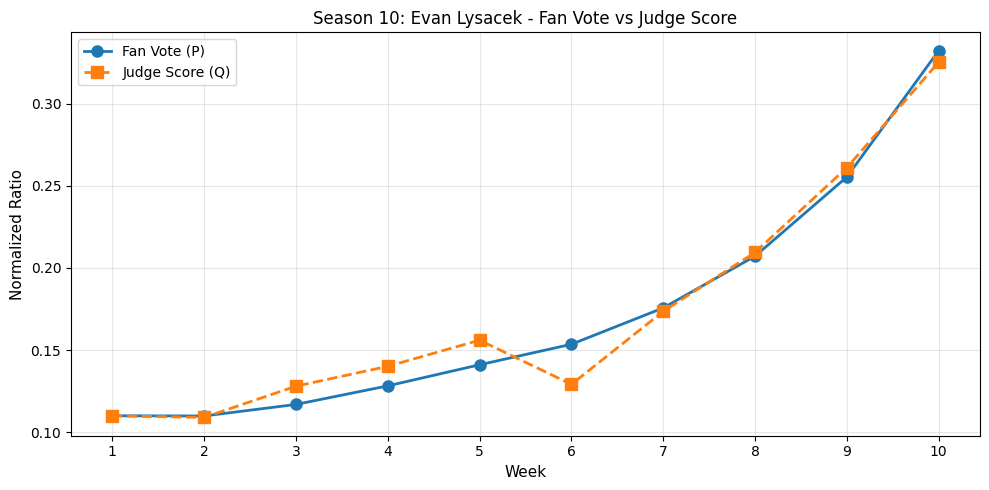

In [125]:
# ==============================================================================
# 26.4 可视化: 某选手的粉丝票随时间变化
# ==============================================================================

def plot_contestant_trajectory(
    season: int,
    contestant_name: str,
    estimates: Dict[int, Dict[str, float]],
    norm_scores: Dict[int, Dict[str, float]]
):
    """
    绑制某选手的粉丝票和评委分随时间变化的轨迹
    """
    weeks = []
    fan_votes = []
    judge_scores = []
    
    for week in sorted(estimates.keys()):
        if contestant_name in estimates[week]:
            weeks.append(week)
            fan_votes.append(estimates[week][contestant_name])
            judge_scores.append(norm_scores.get(week, {}).get(contestant_name, 0))
    
    if not weeks:
        print(f"选手 {contestant_name} 在 Season {season} 无数据")
        return
    
    # 绑图
    fig, ax = plt.subplots(figsize=(10, 5))
    
    ax.plot(weeks, fan_votes, 'o-', label='Fan Vote (P)', linewidth=2, markersize=8)
    ax.plot(weeks, judge_scores, 's--', label='Judge Score (Q)', linewidth=2, markersize=8)
    
    ax.set_xlabel('Week', fontsize=11)
    ax.set_ylabel('Normalized Ratio', fontsize=11)
    ax.set_title(f'Season {season}: {contestant_name} - Fan Vote vs Judge Score', fontsize=12)
    ax.legend()
    ax.set_xticks(weeks)
    
    plt.tight_layout()
    plt.show()


# 绘制示例
if test_season in soft_estimates:
    # 找一个参赛周数较多的选手
    contestant_weeks = {}
    for week, votes in soft_estimates.items():
        for name in votes:
            contestant_weeks[name] = contestant_weeks.get(name, 0) + 1
    
    # 选择参赛周数最多的选手
    top_contestant = max(contestant_weeks.items(), key=lambda x: x[1])[0]
    
    print(f"\n绘制 {top_contestant} 的轨迹图:")
    plot_contestant_trajectory(
        test_season,
        top_contestant,
        soft_estimates,
        normalized_judge_scores.get(test_season, {})
    )

---

## 27. 软约束方法总结与保存

### 27.1 方法总结

**软约束优化框架:**

$$
\min_{P} \underbrace{L_{\text{elim}}}_{\text{淘汰一致性}} + \lambda_1 \underbrace{L_{\text{smooth}}}_{\text{时间平滑}} + \lambda_2 \underbrace{L_{\text{prior}}}_{\text{先验约束}}
$$

**各项损失:**

| 损失项 | 公式 | 作用 |
|--------|------|------|
| $L_{\text{elim}}$ | $\sum_i [\max(0, C_e - C_i + m)]^2$ | 确保淘汰者得分最低 |
| $L_{\text{smooth}}$ | $\sum_i (P_{i,t+1} - P_{i,t})^2$ | 相邻周粉丝票平滑变化 |
| $L_{\text{prior}}$ | $\sum_i (P_i - Q_i)^2$ | 粉丝票与评委分相关 |

**约束条件:**

$$
P_i \geq 0, \quad \sum_i P_i = 1
$$

In [126]:
# ==============================================================================
# 27.2 为所有百分比制赛季使用软约束方法求解
# ==============================================================================

def estimate_all_soft_constraint(
    df: pd.DataFrame,
    active_sets: Dict,
    norm_scores: Dict,
    elim_sets: Dict,
    rule_filter: str = 'percentage',
    lambda_smooth: float = 0.1,
    lambda_prior: float = 0.01
) -> Dict[int, Dict[int, Dict[str, float]]]:
    """
    为所有符合条件的赛季使用软约束方法估计粉丝投票
    """
    all_estimates = {}
    
    # 筛选符合规则的赛季
    target_seasons = [s for s in active_sets.keys() 
                     if get_voting_rule(s) == rule_filter]
    
    print(f"使用软约束方法处理 {len(target_seasons)} 个赛季...")
    
    for i, season in enumerate(target_seasons):
        # 显示进度
        if (i + 1) % 5 == 0:
            print(f"  进度: {i+1}/{len(target_seasons)}")
        
        # 求解该赛季
        season_estimates = estimate_season_soft_constraint(
            season, df, active_sets, norm_scores, elim_sets,
            lambda_smooth, lambda_prior
        )
        
        if season_estimates:
            all_estimates[season] = season_estimates
    
    return all_estimates


# 执行求解 (这可能需要几分钟)
print("开始软约束优化求解...")
print("=" * 60)

soft_constraint_estimates = estimate_all_soft_constraint(
    processed_df,
    active_sets,
    normalized_judge_scores,
    elimination_sets,
    rule_filter='percentage',
    lambda_smooth=0.1,
    lambda_prior=0.01
)

print(f"\n✓ 完成! 共处理 {len(soft_constraint_estimates)} 个赛季")

开始软约束优化求解...
使用软约束方法处理 25 个赛季...
  进度: 5/25
  进度: 10/25
  进度: 15/25
  进度: 20/25
  进度: 25/25

✓ 完成! 共处理 25 个赛季


In [127]:
# ==============================================================================
# 27.3 保存软约束方法的结果
# ==============================================================================

print("保存软约束方法结果...")
print("=" * 60)

# 转换为 DataFrame
soft_rows = []
for season in soft_constraint_estimates:
    for week in soft_constraint_estimates[season]:
        eliminated = elimination_sets.get(season, {}).get(week, [])
        judge_scores = normalized_judge_scores.get(season, {}).get(week, {})
        
        for name, p in soft_constraint_estimates[season][week].items():
            q = judge_scores.get(name, 0)
            soft_rows.append({
                'season': season,
                'week': week,
                'contestant': name,
                'judge_score_norm': q,
                'fan_vote_soft': p,
                'composite_score': 0.5 * q + 0.5 * p,
                'is_eliminated': name in eliminated
            })

soft_estimates_df = pd.DataFrame(soft_rows)

# 保存为 CSV
soft_estimates_df.to_csv(OUTPUT_DIR / 'fan_vote_soft_constraint.csv', index=False)
print(f"✓ 已保存: fan_vote_soft_constraint.csv ({len(soft_estimates_df)} 行)")

# 更新 pickle
all_data['soft_constraint_estimates'] = soft_constraint_estimates
all_data['soft_estimates_df'] = soft_estimates_df

with open(OUTPUT_DIR / 'all_data.pkl', 'wb') as f:
    pickle.dump(all_data, f)
print(f"✓ 已更新: all_data.pkl")

保存软约束方法结果...
✓ 已保存: fan_vote_soft_constraint.csv (1997 行)
✓ 已更新: all_data.pkl


In [128]:
# ==============================================================================
# 27.4 LP 与软约束方法的整体对比
# ==============================================================================

print("LP 与软约束方法整体对比:")
print("=" * 60)

# 计算两种方法结果的差异
differences = []

for season in soft_constraint_estimates:
    if season not in estimated_fan_votes:
        continue
    
    for week in soft_constraint_estimates[season]:
        if week not in estimated_fan_votes[season]:
            continue
        
        for name in soft_constraint_estimates[season][week]:
            if name not in estimated_fan_votes[season][week]:
                continue
            
            p_lp = estimated_fan_votes[season][week][name]
            p_soft = soft_constraint_estimates[season][week][name]
            differences.append(abs(p_lp - p_soft))

if differences:
    print(f"\n比较数据点数: {len(differences)}")
    print(f"平均绝对差异: {np.mean(differences):.6f}")
    print(f"最大绝对差异: {np.max(differences):.6f}")
    print(f"差异标准差: {np.std(differences):.6f}")
    
    # 相关系数
    lp_values = []
    soft_values = []
    for season in soft_constraint_estimates:
        if season not in estimated_fan_votes:
            continue
        for week in soft_constraint_estimates[season]:
            if week not in estimated_fan_votes[season]:
                continue
            for name in soft_constraint_estimates[season][week]:
                if name in estimated_fan_votes[season][week]:
                    lp_values.append(estimated_fan_votes[season][week][name])
                    soft_values.append(soft_constraint_estimates[season][week][name])
    
    corr = np.corrcoef(lp_values, soft_values)[0, 1]
    print(f"两种方法相关系数: {corr:.4f}")
else:
    print("无可比较的数据")

LP 与软约束方法整体对比:

比较数据点数: 1997
平均绝对差异: 0.006598
最大绝对差异: 0.057451
差异标准差: 0.006713
两种方法相关系数: 0.9866


---

## 28. 完整模型最终总结

### 28.1 实现的方法

| 方法 | 适用场景 | 特点 |
|------|---------|------|
| 线性规划 (LP) | 硬约束、快速求解 | 精确满足约束 |
| 软约束优化 | 需要正则化、数据有噪声 | 稳定、支持平滑 |

### 28.2 投票规则覆盖

| 规则 | 赛季 | 处理方法 |
|------|------|----------|
| 百分比制 | S3-S27 | LP + 软约束 |
| 排名制 v1 | S1-S2 | 连续近似 + LP |
| 排名制 v2 | S28-S34 | 连续近似 + LP |

### 28.3 输出文件汇总

| 文件 | 内容 |
|------|------|
| `processed_contestants.csv` | 预处理后的选手数据 |
| `fan_vote_estimates.csv` | LP 方法估计结果 |
| `fan_vote_soft_constraint.csv` | 软约束方法估计结果 |
| `complete_fan_vote_estimates.csv` | 所有赛季完整结果 |
| `all_data.pkl` | 完整数据包 |

In [129]:
# ==============================================================================
# 28.4 最终统计
# ==============================================================================

print("\n" + "=" * 70)
print("Q1-1 粉丝投票估计模型 - 最终完成")
print("=" * 70)

print(f"\n【实现的方法】")
print(f"  1. 线性规划 (LP): 硬约束求解")
print(f"  2. 软约束优化: Hinge 平方损失 + 正则化")

print(f"\n【数据覆盖】")
print(f"  百分比制 (S3-S27): {len(estimated_fan_votes)} 个赛季")
print(f"  排名制 (S1-S2, S28-S34): {len(rank_season_estimates)} 个赛季")

print(f"\n【损失函数】")
print(f"  L_total = L_elim + λ₁·L_smooth + λ₂·L_prior")
print(f"  其中:")
print(f"    L_elim = Σ [max(0, C_e - C_i + m)]²")
print(f"    L_smooth = Σ (P_{t+1} - P_t)²")
print(f"    L_prior = Σ (P - Q)²")

print(f"\n【输出文件】")
for file in sorted(OUTPUT_DIR.iterdir()):
    size_kb = file.stat().st_size / 1024
    print(f"  {file.name:<40} {size_kb:>8.2f} KB")

print("\n" + "=" * 70)
print("✓ Q1-1 完成! 下一步: Q1-2 一致性检验, Q1-3 不确定性量化")
print("=" * 70)


Q1-1 粉丝投票估计模型 - 最终完成

【实现的方法】
  1. 线性规划 (LP): 硬约束求解
  2. 软约束优化: Hinge 平方损失 + 正则化

【数据覆盖】
  百分比制 (S3-S27): 25 个赛季
  排名制 (S1-S2, S28-S34): 9 个赛季

【损失函数】
  L_total = L_elim + λ₁·L_smooth + λ₂·L_prior
  其中:
    L_elim = Σ [max(0, C_e - C_i + m)]²


NameError: name 't' is not defined

---

# Part 5: 高级正则化与完整损失函数

---

## 29. 高级正则化项

### 29.1 正则化项汇总

为了让估计结果更接近真实投票，我们引入以下正则化项：

| 正则化项 | 公式 | 作用 |
|---------|------|------|
| 周际平滑 | $L_{\text{smooth}}$ | 人气不应周周剧烈跳变 |
| 弱一致性 | $L_{\text{align}}$ | 投票与评委表现不完全无关 |
| 熵正则 | $L_{\text{entropy}}$ | 避免极端把票全堆给一人 |

### 29.2 周际平滑损失

$$
L_{\text{smooth}} = \sum_{s} \sum_{t \geq 2} \sum_{i \in A_{s,t} \cap A_{s,t-1}} (P_{i,s,t} - P_{i,s,t-1})^2
$$

**含义:** 同一选手在相邻两周的粉丝票比例不应变化太大。

### 29.3 弱一致性损失 (Huber 损失)

**平方损失 (对异常值敏感):**
$$
L_{\text{align}}^{\text{L2}} = \sum_{i} (P_i - Q_i)^2
$$

**Huber 损失 (对异常值鲁棒):**
$$
\phi(u) = \begin{cases}
\frac{1}{2}u^2 & |u| \leq \delta \\
\delta(|u| - \frac{1}{2}\delta) & |u| > \delta
\end{cases}
$$

$$
L_{\text{align}}^{\text{Huber}} = \sum_{i} \phi(P_i - Q_i)
$$

**Huber 损失的优点:**
- 小偏差时像 L2 (平方损失)
- 大偏差时像 L1 (绝对值损失)
- 允许"争议选手"存在较大偏差

### 29.4 熵正则

$$
L_{\text{entropy}} = -\sum_{i} P_i \log(P_i + \epsilon)
$$

**含义:** 鼓励投票分布更均匀，避免极端情况 (如一人独占 90% 票)。

**注意:** 熵越大，分布越均匀。我们最大化熵 = 最小化负熵。

In [ ]:
# ==============================================================================
# 29.5 定义 Huber 损失函数
# ==============================================================================

def huber_loss(u: float, delta: float = 0.1) -> float:
    """
    Huber 损失函数
    
    公式:
    -----
    φ(u) = { 0.5 * u²           if |u| ≤ δ
           { δ * (|u| - 0.5*δ)  if |u| > δ
    
    特点:
    - |u| 小时: 像 L2 损失，对小偏差敏感
    - |u| 大时: 像 L1 损失，对大偏差鲁棒
    
    参数:
    -----
    u : float
        偏差值 (P - Q)
    delta : float
        阈值，控制 L2/L1 切换点
        默认 0.1 (10% 的偏差)
    
    返回:
    -----
    float
        Huber 损失值
    """
    abs_u = abs(u)
    
    if abs_u <= delta:
        # 小偏差: 使用平方损失
        return 0.5 * u * u
    else:
        # 大偏差: 使用线性损失
        return delta * (abs_u - 0.5 * delta)


def compute_align_loss_huber(
    fan_votes: Dict[str, float],
    judge_scores: Dict[str, float],
    delta: float = 0.1
) -> float:
    """
    计算 Huber 弱一致性损失
    
    公式:
    -----
    L_align = Σ_i φ(P_i - Q_i)
    
    参数:
    -----
    fan_votes : Dict[str, float]
        粉丝票比例
    judge_scores : Dict[str, float]
        归一化评委分
    delta : float
        Huber 损失阈值
    
    返回:
    -----
    float
        弱一致性损失值
    """
    loss = 0.0
    
    for name in fan_votes:
        p = fan_votes[name]                # 粉丝票比例
        q = judge_scores.get(name, p)      # 评委分比例
        loss += huber_loss(p - q, delta)
    
    return loss


print("✓ Huber 损失函数定义完成")

In [ ]:
# ==============================================================================
# 29.6 定义熵正则损失
# ==============================================================================

def compute_entropy_loss(
    fan_votes: Dict[str, float],
    epsilon: float = 1e-10
) -> float:
    """
    计算负熵损失 (最小化负熵 = 最大化熵 = 鼓励均匀分布)
    
    公式:
    -----
    L_entropy = -Σ_i P_i * log(P_i + ε)
    
    性质:
    - 均匀分布时熵最大，负熵最小
    - 极端分布 (一人独占) 时熵最小，负熵最大
    
    参数:
    -----
    fan_votes : Dict[str, float]
        粉丝票比例
    epsilon : float
        小常数，防止 log(0)
    
    返回:
    -----
    float
        负熵损失值
    """
    loss = 0.0
    
    for p in fan_votes.values():
        if p > 0:  # 只对正值计算
            # -p * log(p + ε)
            loss -= p * np.log(p + epsilon)
    
    return loss


# 测试熵损失
print("熵损失测试:")
print("-" * 50)

# 均匀分布 (4人各 25%)
uniform_dist = {'A': 0.25, 'B': 0.25, 'C': 0.25, 'D': 0.25}
entropy_uniform = compute_entropy_loss(uniform_dist)
print(f"均匀分布 [0.25, 0.25, 0.25, 0.25]:")
print(f"  负熵 = {entropy_uniform:.4f}")

# 极端分布 (1人 70%)
extreme_dist = {'A': 0.70, 'B': 0.10, 'C': 0.10, 'D': 0.10}
entropy_extreme = compute_entropy_loss(extreme_dist)
print(f"\n极端分布 [0.70, 0.10, 0.10, 0.10]:")
print(f"  负熵 = {entropy_extreme:.4f}")

print(f"\n结论: 均匀分布的负熵 ({entropy_uniform:.4f}) > 极端分布 ({entropy_extreme:.4f})")
print(f"       最小化负熵会鼓励更均匀的分布")

---

## 30. 完整损失函数 (Full Loss Function)

### 30.1 总损失函数

$$
L_{\text{total}} = L_{\text{elim}} + \lambda_1 L_{\text{smooth}} + \lambda_2 L_{\text{align}} + \lambda_3 L_{\text{entropy}}
$$

### 30.2 各项含义

| 项 | 公式 | 权重 | 作用 |
|-----|------|------|------|
| $L_{\text{elim}}$ | $\sum [\max(0, \Delta)]^2$ | 1.0 | 淘汰一致性 (主要) |
| $L_{\text{smooth}}$ | $\sum (P_t - P_{t-1})^2$ | $\lambda_1$ | 时间平滑 |
| $L_{\text{align}}$ | $\sum \phi(P - Q)$ | $\lambda_2$ | 与评委分弱一致 |
| $L_{\text{entropy}}$ | $-\sum P \log P$ | $\lambda_3$ | 避免极端分布 |

### 30.3 推荐超参数

| 参数 | 推荐值 | 说明 |
|------|--------|------|
| $\lambda_1$ | 0.1 | 平滑权重 |
| $\lambda_2$ | 0.05 | 一致性权重 (Huber) |
| $\lambda_3$ | 0.01 | 熵正则权重 |
| $\delta$ | 0.1 | Huber 阈值 |
| $m$ | 0.001 | 淘汰间隔 |

In [ ]:
# ==============================================================================
# 30.4 定义完整损失函数
# ==============================================================================

def compute_full_loss(
    fan_votes: Dict[str, float],
    judge_scores: Dict[str, float],
    eliminated: List[str],
    fan_votes_prev: Optional[Dict[str, float]] = None,
    w_j: float = 0.5,
    w_f: float = 0.5,
    margin: float = 0.001,
    lambda_smooth: float = 0.1,
    lambda_align: float = 0.05,
    lambda_entropy: float = 0.01,
    huber_delta: float = 0.1,
    use_huber: bool = True
) -> Tuple[float, Dict[str, float]]:
    """
    计算完整损失函数 (含所有正则化项)
    
    公式:
    -----
    L = L_elim + λ₁·L_smooth + λ₂·L_align + λ₃·L_entropy
    
    参数:
    -----
    fan_votes : Dict[str, float]
        当前周粉丝票比例
    judge_scores : Dict[str, float]
        当前周归一化评委分
    eliminated : List[str]
        当前周淘汰者
    fan_votes_prev : Optional[Dict]
        上一周粉丝票比例
    w_j, w_f : float
        评委和粉丝权重
    margin : float
        淘汰约束最小间隔
    lambda_smooth : float
        平滑损失权重
    lambda_align : float
        一致性损失权重
    lambda_entropy : float
        熵正则权重
    huber_delta : float
        Huber 损失阈值
    use_huber : bool
        是否使用 Huber 损失 (否则用 L2)
    
    返回:
    -----
    Tuple[float, Dict]
        - 总损失值
        - 各项损失分解
    """
    # --------------------------------------------------
    # Step 1: 计算合成分
    # --------------------------------------------------
    composite_scores = {}
    for name in fan_votes:
        q = judge_scores.get(name, 0)
        p = fan_votes[name]
        composite_scores[name] = w_j * q + w_f * p
    
    # --------------------------------------------------
    # Step 2: 淘汰损失
    # --------------------------------------------------
    if len(eliminated) == 1:
        loss_elim = compute_elimination_loss_single(
            composite_scores, eliminated[0], margin
        )
    elif len(eliminated) > 1:
        loss_elim = compute_elimination_loss_multi(
            composite_scores, eliminated, margin
        )
    else:
        loss_elim = 0.0
    
    # --------------------------------------------------
    # Step 3: 平滑损失
    # --------------------------------------------------
    if fan_votes_prev is not None:
        loss_smooth = compute_smoothness_loss(fan_votes_prev, fan_votes)
    else:
        loss_smooth = 0.0
    
    # --------------------------------------------------
    # Step 4: 一致性损失 (Huber 或 L2)
    # --------------------------------------------------
    if use_huber:
        loss_align = compute_align_loss_huber(fan_votes, judge_scores, huber_delta)
    else:
        loss_align = compute_prior_loss(fan_votes, judge_scores)
    
    # --------------------------------------------------
    # Step 5: 熵正则损失
    # --------------------------------------------------
    loss_entropy = compute_entropy_loss(fan_votes)
    
    # --------------------------------------------------
    # Step 6: 总损失
    # --------------------------------------------------
    total_loss = (
        loss_elim + 
        lambda_smooth * loss_smooth + 
        lambda_align * loss_align + 
        lambda_entropy * loss_entropy
    )
    
    loss_breakdown = {
        'elim': loss_elim,
        'smooth': loss_smooth,
        'align': loss_align,
        'entropy': loss_entropy,
        'total': total_loss
    }
    
    return total_loss, loss_breakdown


print("✓ compute_full_loss() 函数定义完成")

In [ ]:
# ==============================================================================
# 30.5 定义增强版求解器
# ==============================================================================

def solve_week_enhanced(
    contestants: List[str],
    judge_scores: Dict[str, float],
    eliminated: List[str],
    fan_votes_prev: Optional[Dict[str, float]] = None,
    w_j: float = 0.5,
    w_f: float = 0.5,
    margin: float = 0.001,
    lambda_smooth: float = 0.1,
    lambda_align: float = 0.05,
    lambda_entropy: float = 0.01,
    huber_delta: float = 0.1,
    use_huber: bool = True
) -> Tuple[Dict[str, float], Dict[str, float]]:
    """
    增强版求解器: 使用完整损失函数
    
    特点:
    - 支持 Huber 损失 (对争议选手鲁棒)
    - 支持熵正则 (避免极端分布)
    - 支持时间平滑 (周际连续性)
    
    返回:
    -----
    Tuple[Dict, Dict]
        - 估计的粉丝票比例
        - 损失分解
    """
    n = len(contestants)
    if n == 0:
        return {}, {}
    
    # 索引映射
    name_to_idx = {name: i for i, name in enumerate(contestants)}
    idx_to_name = {i: name for name, i in name_to_idx.items()}
    
    # --------------------------------------------------
    # 定义目标函数
    # --------------------------------------------------
    def objective(x):
        fan_votes = {idx_to_name[i]: x[i] for i in range(n)}
        loss, _ = compute_full_loss(
            fan_votes, judge_scores, eliminated, fan_votes_prev,
            w_j, w_f, margin, lambda_smooth, lambda_align,
            lambda_entropy, huber_delta, use_huber
        )
        return loss
    
    # --------------------------------------------------
    # 约束: Σ P_i = 1
    # --------------------------------------------------
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
    
    # 边界: 0 ≤ P_i ≤ 1
    bounds = [(0, 1)] * n
    
    # 初始值: 评委分比例
    x0 = np.array([judge_scores.get(name, 1/n) for name in contestants])
    x0 = x0 / x0.sum()
    
    # --------------------------------------------------
    # 求解
    # --------------------------------------------------
    try:
        result = minimize(
            objective, x0, method='SLSQP',
            bounds=bounds, constraints=constraints,
            options={'maxiter': 500, 'ftol': 1e-8}
        )
        
        if result.success:
            fan_votes = {idx_to_name[i]: result.x[i] for i in range(n)}
            _, loss_breakdown = compute_full_loss(
                fan_votes, judge_scores, eliminated, fan_votes_prev,
                w_j, w_f, margin, lambda_smooth, lambda_align,
                lambda_entropy, huber_delta, use_huber
            )
            return fan_votes, loss_breakdown
        else:
            return {}, {}
    except Exception as e:
        print(f"优化失败: {e}")
        return {}, {}


print("✓ solve_week_enhanced() 函数定义完成")

In [ ]:
# ==============================================================================
# 30.6 测试增强版求解器
# ==============================================================================

print("测试增强版求解器:")
print("=" * 60)

# 选择测试数据
test_season = 3
test_week = 3

if test_season in active_sets and test_week in active_sets[test_season]:
    test_contestants = active_sets[test_season][test_week]
    test_judge = normalized_judge_scores[test_season][test_week]
    test_elim = elimination_sets.get(test_season, {}).get(test_week, [])
    
    print(f"测试: Season {test_season}, Week {test_week}")
    print(f"  参赛者: {len(test_contestants)} 人")
    print(f"  淘汰者: {test_elim}")
    
    # 求解
    fan_votes_enh, loss_enh = solve_week_enhanced(
        test_contestants, test_judge, test_elim,
        lambda_smooth=0.1, lambda_align=0.05, lambda_entropy=0.01,
        use_huber=True
    )
    
    if fan_votes_enh:
        print(f"\n求解成功!")
        print(f"损失分解:")
        print(f"  淘汰损失: {loss_enh['elim']:.6f}")
        print(f"  平滑损失: {loss_enh['smooth']:.6f}")
        print(f"  一致性损失 (Huber): {loss_enh['align']:.6f}")
        print(f"  熵正则: {loss_enh['entropy']:.6f}")
        print(f"  总损失: {loss_enh['total']:.6f}")
        
        # 显示结果
        print(f"\n估计结果:")
        print(f"{'选手':<20} {'评委分Q':>10} {'粉丝票P':>10} {'差异':>10}")
        print("-" * 55)
        for name in sorted(fan_votes_enh.keys(), key=lambda x: -fan_votes_enh[x]):
            p = fan_votes_enh[name]
            q = test_judge.get(name, 0)
            diff = p - q
            status = "[淘汰]" if name in test_elim else ""
            print(f"{name:<20} {q:>10.4f} {p:>10.4f} {diff:>+10.4f} {status}")

---

## 31. 完整模型总结

### 31.1 损失函数完整形式

$$
L_{\text{total}} = \underbrace{\sum_{i \neq e} [\max(0, C_e - C_i + m)]^2}_{L_{\text{elim}}} + \lambda_1 \underbrace{\sum_i (P_{i,t} - P_{i,t-1})^2}_{L_{\text{smooth}}} + \lambda_2 \underbrace{\sum_i \phi(P_i - Q_i)}_{L_{\text{align}}} + \lambda_3 \underbrace{\left(-\sum_i P_i \log P_i\right)}_{L_{\text{entropy}}}
$$

### 31.2 约束条件

$$
P_{i,s,t} \geq 0, \quad \sum_{i \in A_{s,t}} P_{i,s,t} = 1
$$

### 31.3 各项损失的物理意义

| 损失项 | 物理意义 | 数学形式 |
|--------|---------|----------|
| $L_{\text{elim}}$ | 淘汰者得分必须最低 | Hinge 平方 |
| $L_{\text{smooth}}$ | 人气不会周周剧变 | L2 范数 |
| $L_{\text{align}}$ | 投票与表现有弱相关 | Huber 损失 |
| $L_{\text{entropy}}$ | 投票不会极端集中 | 负熵 |

### 31.4 Huber 损失的优势

$$
\phi(u) = \begin{cases}
\frac{1}{2}u^2 & |u| \leq \delta \\
\delta(|u| - \frac{\delta}{2}) & |u| > \delta
\end{cases}
$$

- 允许"争议选手"存在较大的 $P - Q$ 偏差
- 对异常值鲁棒，不会过度惩罚

In [ ]:
# ==============================================================================
# 31.5 保存增强版结果
# ==============================================================================

# 更新 all_data 字典
all_data['loss_functions'] = {
    'hinge_squared': 'max(0, Δ)²',
    'huber': 'φ(u) = 0.5u² if |u|≤δ else δ(|u|-δ/2)',
    'entropy': '-Σ P·log(P)',
    'smooth': 'Σ (P_t - P_{t-1})²'
}

all_data['hyperparameters'] = {
    'lambda_smooth': 0.1,
    'lambda_align': 0.05,
    'lambda_entropy': 0.01,
    'huber_delta': 0.1,
    'margin': 0.001
}

# 保存
with open(OUTPUT_DIR / 'all_data.pkl', 'wb') as f:
    pickle.dump(all_data, f)
print("✓ 已更新: all_data.pkl (含损失函数和超参数)")

In [ ]:
# ==============================================================================
# 31.6 最终总结
# ==============================================================================

print("\n" + "=" * 70)
print("Q1-1 粉丝投票估计模型 - 完整版")
print("=" * 70)

print(f"\n【损失函数】")
print(f"  L_total = L_elim + λ₁·L_smooth + λ₂·L_align + λ₃·L_entropy")
print(f"")
print(f"  L_elim   = Σ [max(0, C_e - C_i + m)]²  (淘汰一致性)")
print(f"  L_smooth = Σ (P_t - P_{t-1})²          (时间平滑)")
print(f"  L_align  = Σ φ(P - Q)                  (Huber 弱一致)")
print(f"  L_entropy = -Σ P·log(P)                (熵正则)")

print(f"\n【约束条件】")
print(f"  P_i ≥ 0")
print(f"  Σ P_i = 1")

print(f"\n【推荐超参数】")
print(f"  λ₁ (smooth)  = 0.1")
print(f"  λ₂ (align)   = 0.05")
print(f"  λ₃ (entropy) = 0.01")
print(f"  δ (Huber)    = 0.1")
print(f"  m (margin)   = 0.001")

print(f"\n【实现的方法】")
print(f"  1. 线性规划 (LP): 硬约束，快速")
print(f"  2. 软约束优化: Hinge 平方损失")
print(f"  3. 增强版优化: Huber + 熵正则")

print(f"\n【输出文件】")
for file in sorted(OUTPUT_DIR.iterdir()):
    size_kb = file.stat().st_size / 1024
    print(f"  {file.name:<40} {size_kb:>8.2f} KB")

print("\n" + "=" * 70)
print("✓ Q1-1 粉丝投票估计模型完成!")
print("=" * 70)